In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy
from astropy import units as u
import astromet
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import scanninglaw.times
from scanninglaw.source import Source
import h5py
import seaborn as sns

In [3]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [4]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 32.929 s
  auxilliary:  14.679 s
          sf:   3.799 s
interpolator:  14.450 s


In [5]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [32]:
gums_file='data/gums_sample_reparameterised.h'

with h5py.File(gums_file, 'r') as f:
    gums = {}
    for key in f.keys():
        gums[key] = f[key][...]
print(gums.keys())

fits_file='data/gums_fits_singlesandunresolved_parallel.h'

with h5py.File(fits_file, 'r') as f:
    fits = {k:v[:] for k,v in f.items()}
print(fits.keys())

delta_file='data/gums_fits_unresolved_dr2&3.h'

with h5py.File(delta_file, 'r') as f:
    delta = {k:v[:] for k,v in f.items()}
print(delta.keys())

dict_keys(['a', 'age', 'alphafe', 'barycentric_distance', 'binary', 'dec', 'e', 'feh', 'flipped', 'inclination', 'l', 'longitude_ascending_node', 'parallax', 'periastron_argument', 'periastron_date', 'period', 'phot_g_mean_mag', 'pmdec', 'pmra', 'population', 'primary_logg', 'primary_mag_bp', 'primary_mag_g', 'primary_mag_rp', 'primary_mag_rvs', 'primary_mass', 'primary_radius', 'primary_teff', 'primary_variability_amplitude', 'primary_variability_period', 'primary_variability_phase', 'primary_variability_type', 'primary_vsini', 'q', 'ra', 'radial_velocity', 'secondary_logg', 'secondary_mag_bp', 'secondary_mag_g', 'secondary_mag_rp', 'secondary_mag_rvs', 'secondary_mass', 'secondary_radius', 'secondary_teff', 'secondary_variability_amplitude', 'secondary_variability_period', 'secondary_variability_phase', 'secondary_variability_type', 'secondary_vsini', 'system_id', 'tperi', 'unresolved', 'vomega', 'vphi', 'vtheta'])
dict_keys(['UWE', 'astrometric_chi2_al', 'astrometric_excess_noise', 

In [33]:
# single star data
singles=np.flatnonzero(gums['binary']==False)

sras=gums['ra'][singles]
sdecs=gums['dec'][singles]
spmras=gums['pmra'][singles]
spmdecs=gums['pmdec'][singles]
spllxs=1000/gums['barycentric_distance'][singles]
smags=gums['primary_mag_g'][singles]

In [52]:
# binary star data
binaries=np.flatnonzero(gums['binary']==True)

pllxs=1000/gums['barycentric_distance'] # mas
semis=gums['a'] # au
eccs=gums['e']
# randomly generating viewing angles because I got too confused by the argument of pericentre
vthetas=gums['vtheta']#np.arccos(-1+2*np.random.rand(pllxs.size)) # rad
vphis=gums['vphi']#2*np.pi*np.random.rand(pllxs.size) # rad
vomegas=gums['vomega']#2*np.pi*np.random.rand(pllxs.size) # rad

periods=gums['period']#gums['orbit_period']/astromet.T # years

tperis=gums['tperi']#2016+gums['periastron_date']/astromet.T
tot_mags=gums['phot_g_mean_mag']#-2.5*np.log10(10**(-0.4*gums['primary_mag_g'])+10**(-0.4*gums['secondary_mag_g']))
ptot_mags=gums['primary_mag_g']
stot_mags=gums['secondary_mag_g']
atot_mags=tot_mags - 10 + 5*np.log10(pllxs)
aptot_mags=ptot_mags - 10 + 5*np.log10(pllxs)
astot_mags=stot_mags - 10 + 5*np.log10(pllxs)
bps=-2.5*np.log10(10**(-0.4*gums['primary_mag_bp'])+10**(-0.4*gums['secondary_mag_bp']))
rps=-2.5*np.log10(10**(-0.4*gums['primary_mag_rp'])+10**(-0.4*gums['secondary_mag_rp']))
pcols=gums['primary_mag_bp']-gums['primary_mag_rp']
scols=gums['secondary_mag_bp']-gums['secondary_mag_rp']
cols=bps-rps
ls=gums['l']#10**(0.4*(gums['primary_mag_g']-gums['secondary_mag_g']))
qs=gums['q']#gums['secondary_mass']/gums['primary_mass']
deltas=np.abs(qs-ls)/((1+ls)*(1+qs))

misordered=np.flatnonzero(ls>1)
ls[misordered]=1/ls[misordered]
qs[misordered]=1/qs[misordered]

max_proj_sep=semis*pllxs*(1+eccs)*np.cos(vthetas)

ubins=np.flatnonzero((gums['binary']==True) & (max_proj_sep<180) & (periods<100)) # unresolved binaries
ualtbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep<180))
#rbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep>180)) # (partially) resolved binaries
nall=gums['ra'].size
nsingle=singles.size
nbinary=ubins.size
nother=nall-nsingle-nbinary


print(nall,' sources in 100 pc')
print(nsingle,' single sources')
print(nbinary,' unresolved binaries w. period < 100 years')
print(nother,' other sources')
print('(',ualtbins.size,' all unresolved binaries)')


uids=gums['system_id'][ubins]

uras=gums['ra'][ubins]
udecs=gums['dec'][ubins]
upmras=gums['pmra'][ubins]
upmdecs=gums['pmdec'][ubins]
upllxs=pllxs[ubins]

uperiods=periods[ubins]
uas=semis[ubins]
ues=eccs[ubins]

uls=ls[ubins]
uqs=qs[ubins]
udeltas=deltas[ubins]
utperis=tperis[ubins]

uvthetas=vthetas[ubins]
uvphis=vphis[ubins]
uvomegas=vomegas[ubins]

umags=tot_mags[ubins]
uamags=atot_mags[ubins]
ucols=cols[ubins]

puamags=aptot_mags[ubins]
pucols=pcols[ubins]

suamags=astot_mags[ubins]
sucols=scols[ubins]

126314  sources in 100 pc
93606  single sources
14431  unresolved binaries w. period < 100 years
18277  other sources
( 24809  all unresolved binaries)


In [39]:
# fit data
fids=fits['system_id']

fuwes=fits['UWE']
fras=fits['ra']
fraerrs=fits['ra_error']
fdecs=fits['dec']
fdecerrs=fits['dec_error']
fpllxs=fits['parallax']
fpllxerrs=fits['parallax_error']
fpmras=fits['pmra']
fpmraerrs=fits['pmra_error']
fpmdecs=fits['pmdec']
fpmdecerrs=fits['pmdec_error']

# inidices to pick out single stars
_,fsingles,_ = np.intersect1d(fits['system_id'], gums['system_id'][singles], return_indices=True)
_,fbinaries,_ = np.intersect1d(fits['system_id'], gums['system_id'][ubins], return_indices=True)

In [40]:
wdsel=np.flatnonzero((ucols<1.8) & (uamags-3*ucols > 9.5))
dwarfsel=np.flatnonzero((ucols>1.8) & (uamags > 13.4)
              & (uamags+(4/3)*ucols >17.4))
giantsel=np.flatnonzero((uamags < 3.8) & (ucols>0.9))
ymssel=np.flatnonzero((uamags < 3.8) & (ucols<0.9))
mssel=np.flatnonzero((uamags > 3.8) & (uamags < 13.4)
           & (uamags-3.2*ucols < 3.8))
smssel=np.flatnonzero((uamags+(4/3)*ucols <17.4) & (uamags-3.2*ucols > 3.8)
           & (uamags-3*ucols < 9.5) & (uamags>3.8))

wdprim=np.flatnonzero((pucols<1.8) & (puamags-3*pucols > 9.5))
dwarfprim=np.flatnonzero((pucols>1.8) & (puamags > 13.4)
              & (puamags+(4/3)*pucols >17.4))
giantprim=np.flatnonzero((puamags < 3.8) & (pucols>0.9))
ymsprim=np.flatnonzero((puamags < 3.8) & (pucols<0.9))
msprim=np.flatnonzero((puamags > 3.8) & (puamags < 13.4)
           & (puamags-3.2*pucols < 3.8))
smsprim=np.flatnonzero((puamags+(4/3)*pucols <17.4) & (puamags-3.2*pucols > 3.8)
           & (puamags-3*pucols < 9.5) & (puamags>3.8))

wdsec=np.flatnonzero((sucols<1.8) & (suamags-3*sucols > 9.5))
dwarfsec=np.flatnonzero((sucols>1.8) & (suamags > 13.4)
              & (suamags+(4/3)*sucols >17.4))
giantsec=np.flatnonzero((suamags < 3.8) & (sucols>0.9))
ymssec=np.flatnonzero((suamags < 3.8) & (sucols<0.9))
mssec=np.flatnonzero((suamags > 3.8) & (suamags < 13.4)
           & (suamags-3.2*sucols < 3.8))
smssec=np.flatnonzero((suamags+(4/3)*sucols <17.4) & (suamags-3.2*sucols > 3.8)
           & (suamags-3*sucols < 9.5) & (suamags>3.8))

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


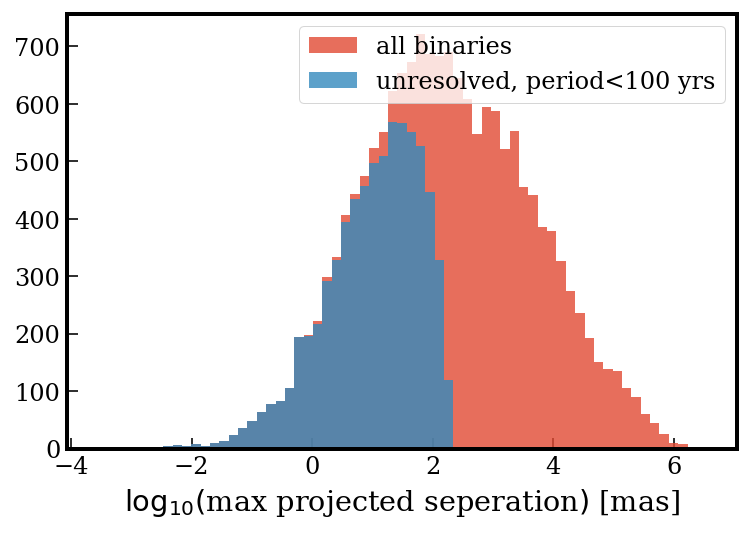

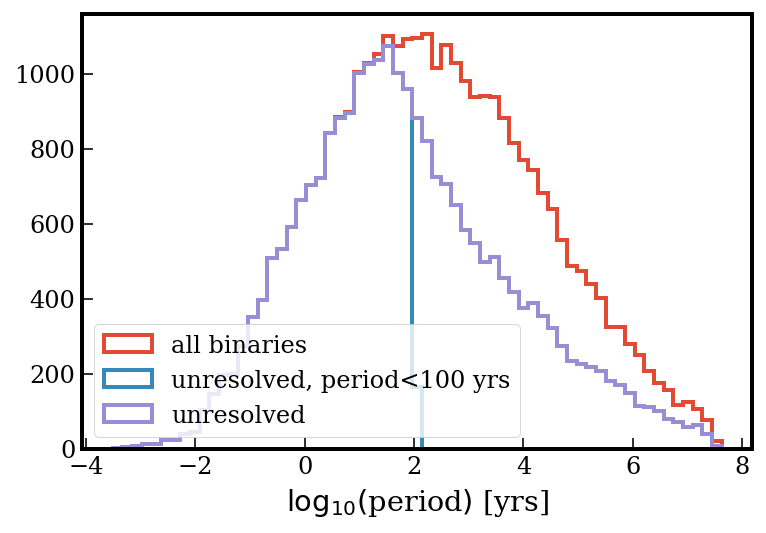

14431  unresolved binaries with period < 100 years 
 out of  126314  sources containing  32708  binaries.


In [41]:
#rbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep>180) & (periods<30))
ax=plt.gca()
_,bins,_=ax.hist(np.log10(max_proj_sep[binaries]),bins='auto',label='all binaries',alpha=0.8)
ax.hist(np.log10(max_proj_sep[ubins]),bins=bins,label='unresolved, period<100 yrs',alpha=0.8)
#ax.hist(np.log10(max_proj_sep[rbins]),bins=bins,label='resolved, period<30 yrs',alpha=0.8)
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}($max projected seperation$)$ [mas]')
plt.legend()
plt.show()

ax=plt.gca()
_,bins,_=ax.hist(np.log10(periods[binaries]),bins='auto',label='all binaries',histtype='step',lw=2)
ax.hist(np.log10(periods[ubins]),bins=bins,label='unresolved, period<100 yrs',histtype='step',lw=2)
ax.hist(np.log10(periods[ualtbins]),bins=bins,label='unresolved',histtype='step',lw=2)
#ax.hist(np.log10(max_proj_sep[rbins]),bins=bins,label='resolved, period<30 yrs',alpha=0.8)
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}($period$)$ [yrs]')
plt.legend(loc=3)
plt.show()
print(ubins.size,' unresolved binaries with period < 100 years \n out of ',
      pllxs.size,' sources containing ',binaries.size,' binaries.')

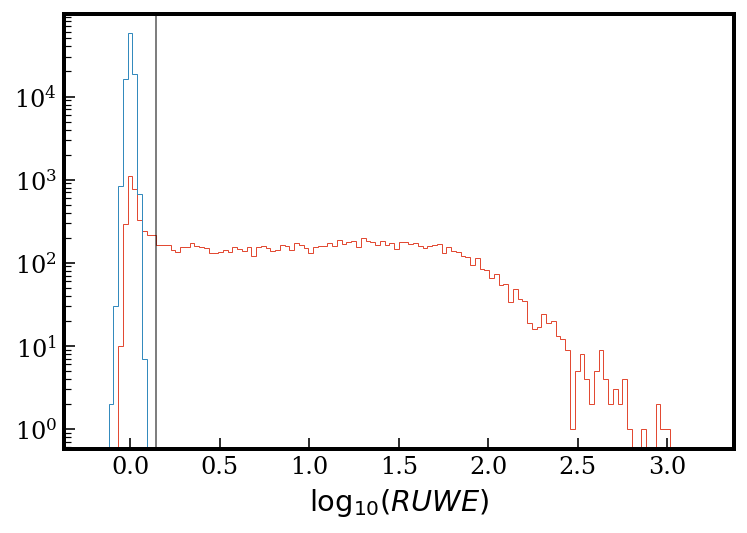

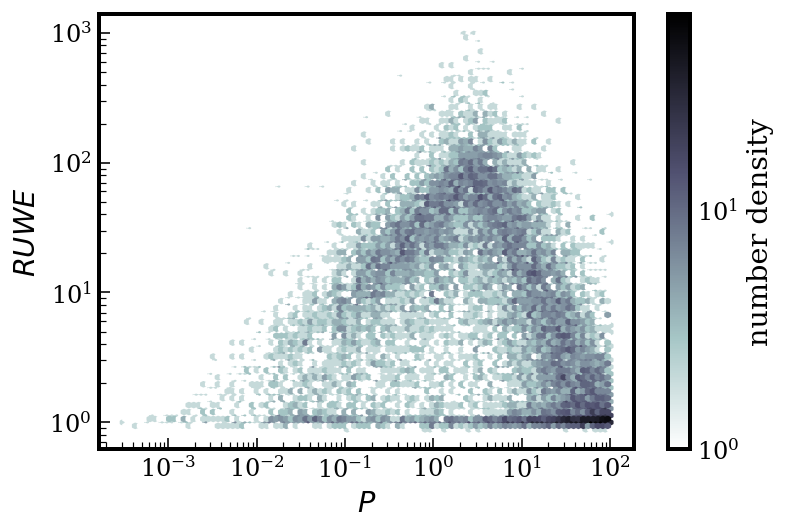

In [42]:
ax=plt.gca()
_,bins,_=ax.hist(np.log10(fuwes[fbinaries]),range=(-0.2,3.2),bins=128,histtype='step')
ax.hist(np.log10(fuwes[fsingles]),bins=bins,histtype='step')
ax.axvline(np.log10(1.4),c='k',lw=1,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(RUWE)$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uperiods,fuwes[fbinaries],xscale='log',yscale='log',cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
ax.set_ylabel(r'$RUWE$')
ax.set_xlabel(r'$P$')
plt.show()


/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  from ipykernel import kernelapp as app


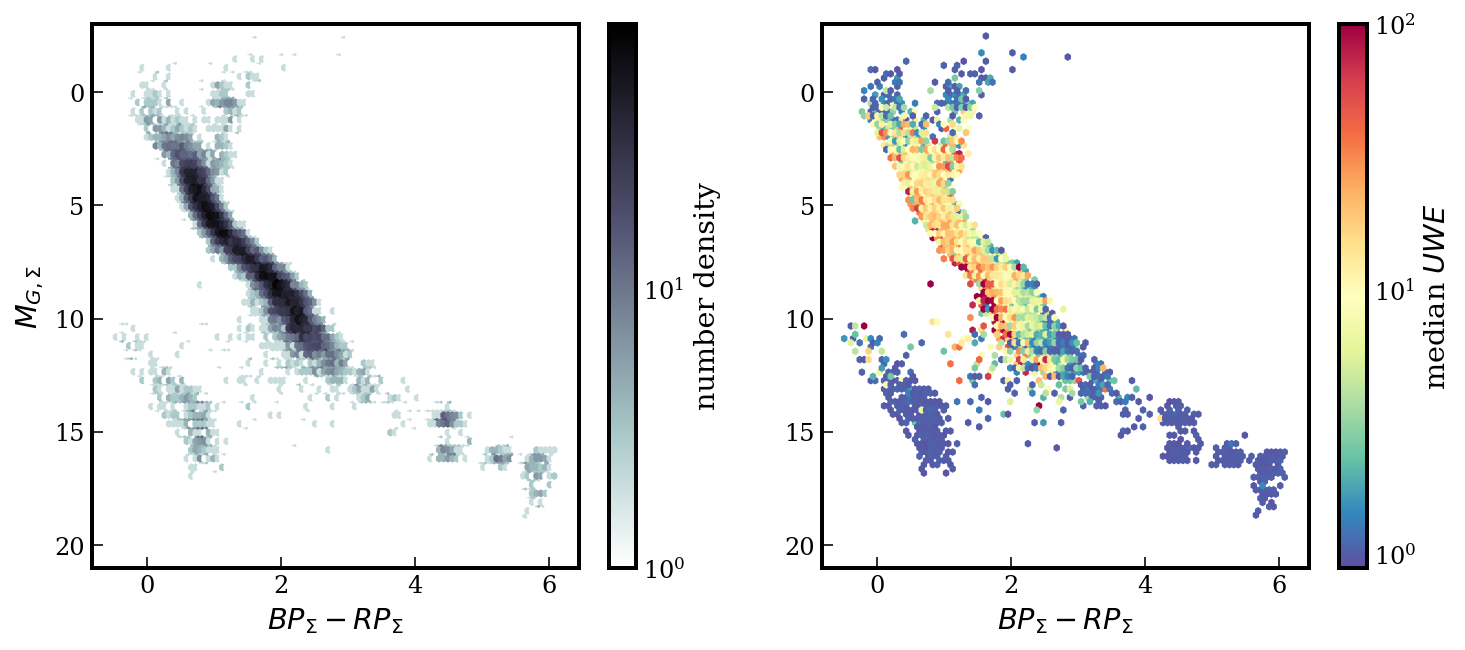

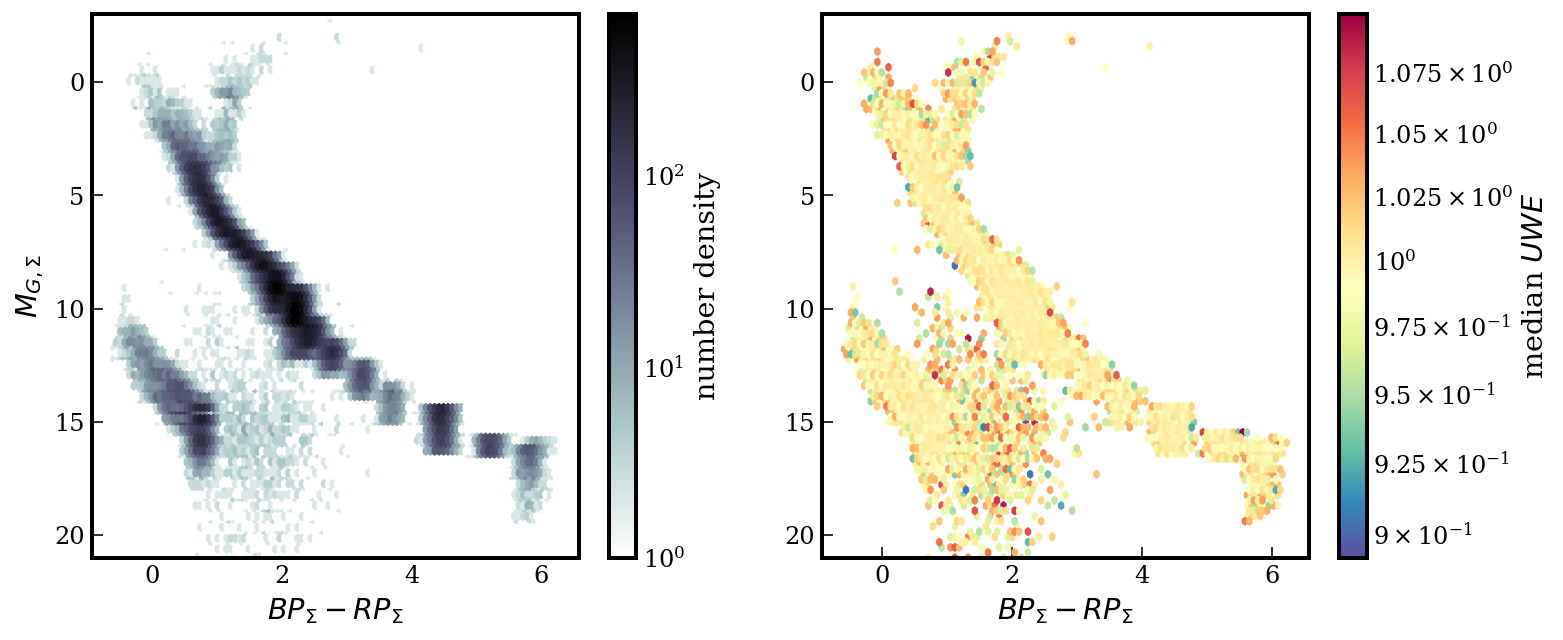

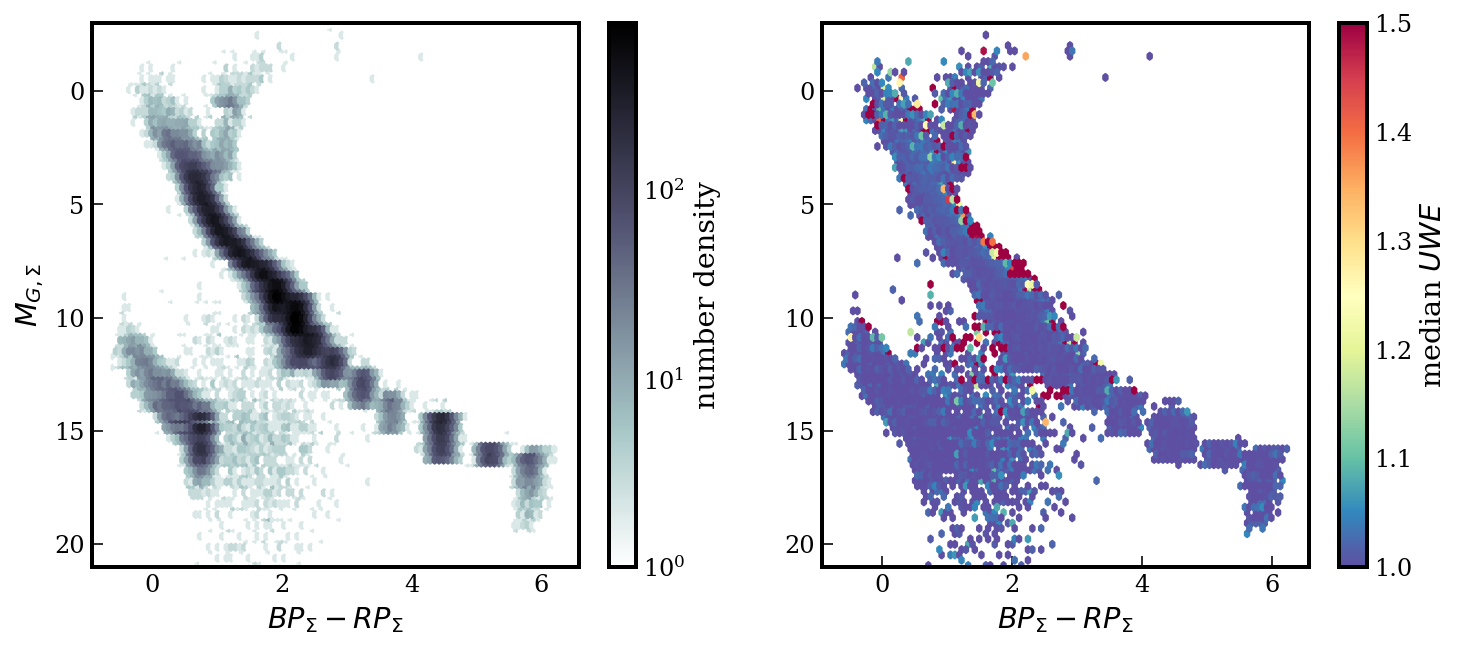

In [44]:
# single star colours quantized so adding some random noise
bcols=ucols+0.1*np.random.randn(ubins.size)

fig=plt.figure(figsize=(12,5))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
im=ax.hexbin(bcols,uamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(bcols,uamags,C=fuwes[fbinaries],reduce_C_function=np.median,
             cmap='Spectral_r',bins='log',vmax=100)
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
plt.show()

# single star colours quantized so adding some random noise
scols=pcols[singles]+0.1*np.random.randn(singles.size)

fig=plt.figure(figsize=(12,5))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
im=ax.hexbin(scols,atot_mags[singles],cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(scols,atot_mags[singles],C=fuwes[fsingles],reduce_C_function=np.median,
             cmap='Spectral_r',bins='log')
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
plt.show()

allcols=np.hstack([bcols,scols])
allamags=np.hstack([uamags,atot_mags[singles]])
alluwes=np.hstack([fuwes[fbinaries],fuwes[fsingles]])

fig=plt.figure(figsize=(12,5))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
im=ax.hexbin(allcols,allamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(allcols,allamags,C=alluwes,reduce_C_function=np.median,
             cmap='Spectral_r',vmax=1.5,vmin=1)
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
plt.show()

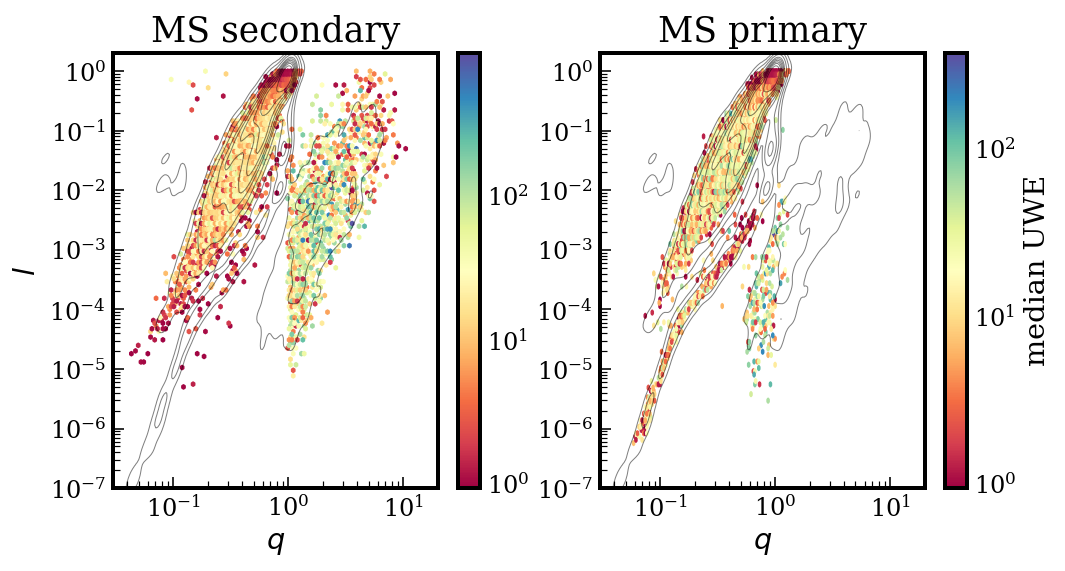

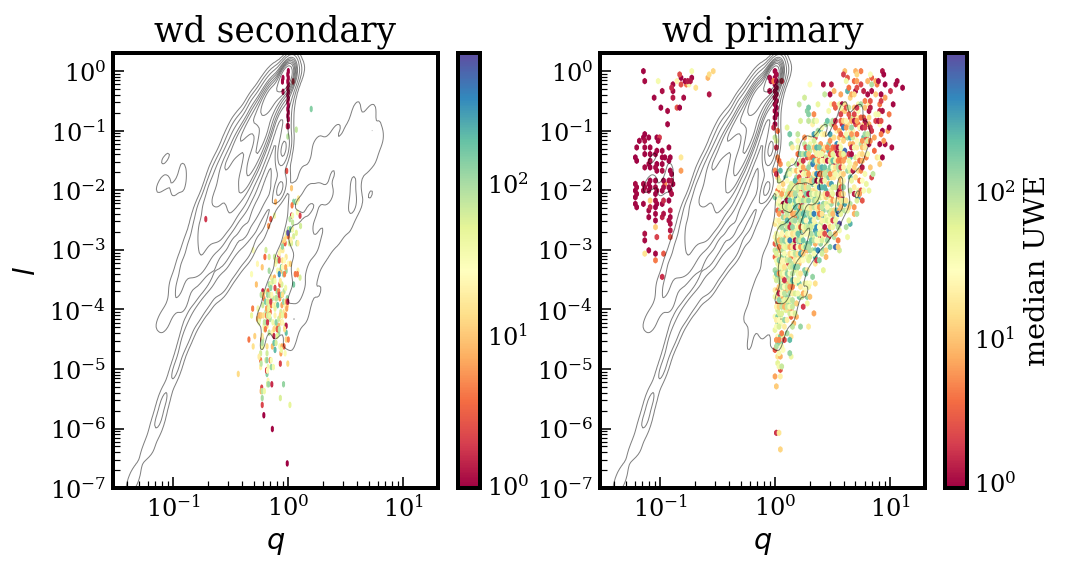

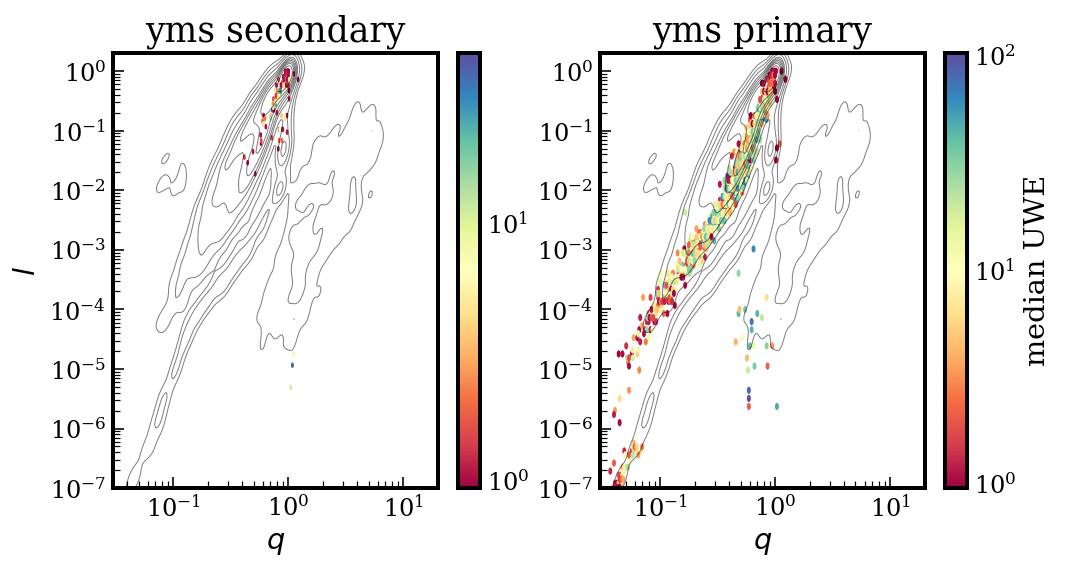

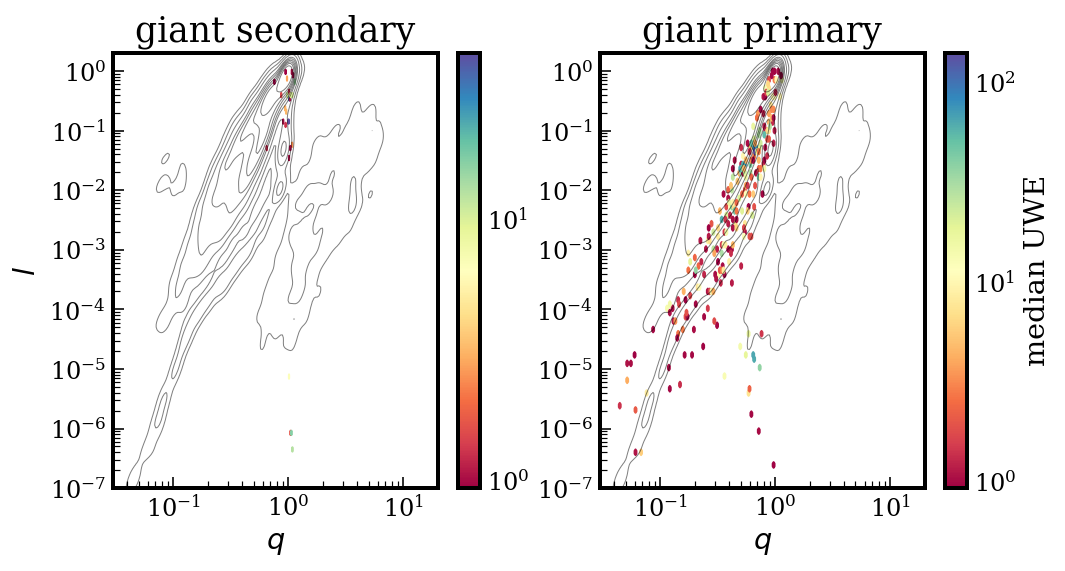

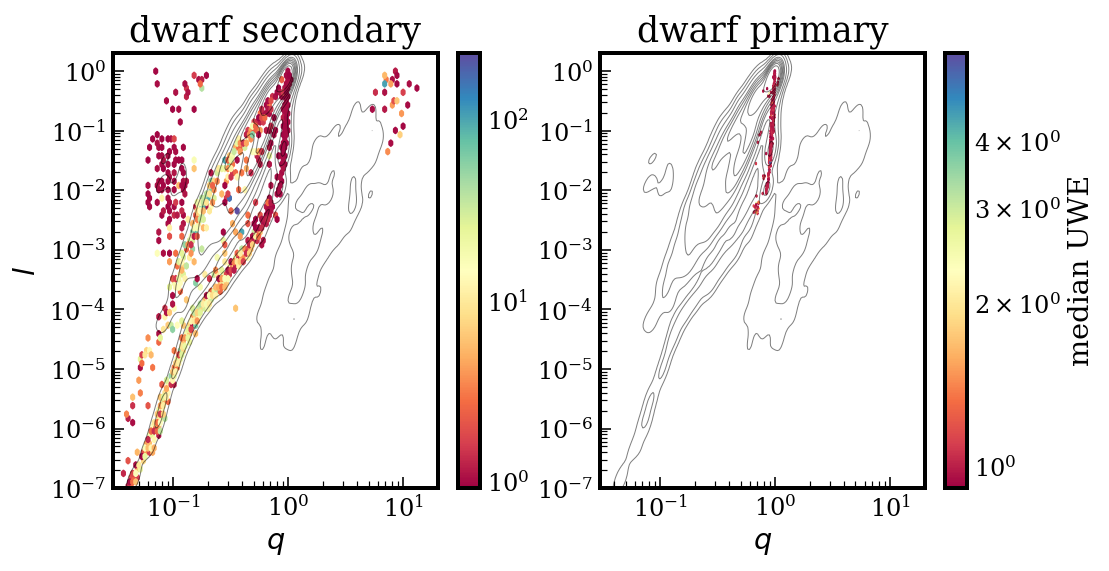

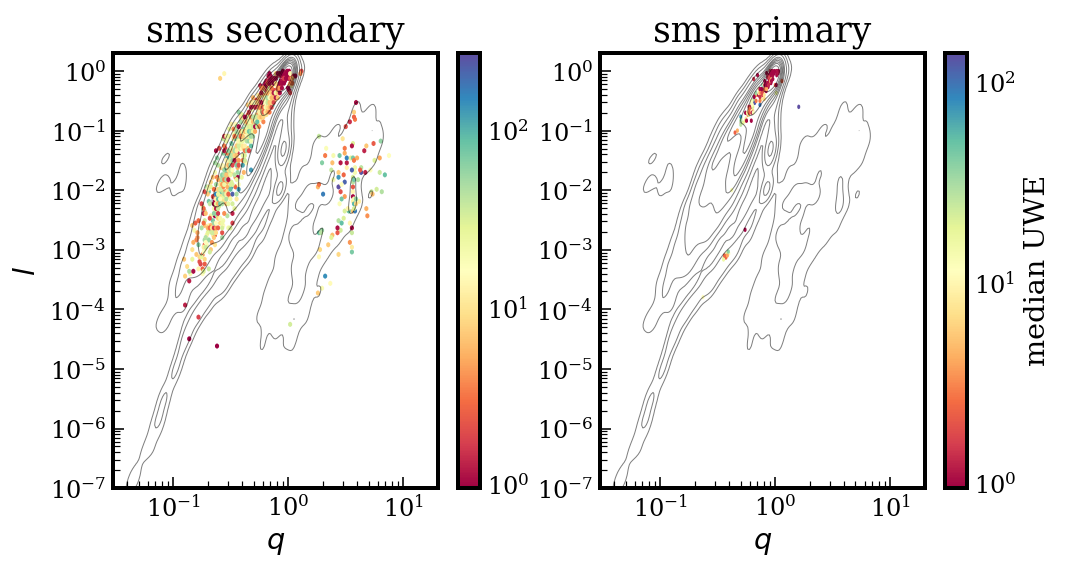

In [46]:
fig=plt.figure(figsize=(10,4))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
ax.set_title('MS secondary')
im=ax.hexbin(uqs[mssec],uls[mssec],C=fuwes[fbinaries[mssec]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$l$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)

ax=plt.subplot(grid[0,1])
ax.set_title('MS primary')
im=ax.hexbin(uqs[msprim],uls[msprim],C=fuwes[fbinaries[msprim]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im,label='median UWE')
ax.set_xlabel(r'$q$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)
plt.show()

fig=plt.figure(figsize=(10,4))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
ax.set_title('wd secondary')
im=ax.hexbin(uqs[wdsec],uls[wdsec],C=fuwes[fbinaries[wdsec]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$l$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)

ax=plt.subplot(grid[0,1])
ax.set_title('wd primary')
im=ax.hexbin(uqs[wdprim],uls[wdprim],C=fuwes[fbinaries[wdprim]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im,label='median UWE')
ax.set_xlabel(r'$q$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)
plt.show()

fig=plt.figure(figsize=(10,4))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
ax.set_title('yms secondary')
im=ax.hexbin(uqs[ymssec],uls[ymssec],C=fuwes[fbinaries[ymssec]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$l$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)

ax=plt.subplot(grid[0,1])
ax.set_title('yms primary')
im=ax.hexbin(uqs[ymsprim],uls[ymsprim],C=fuwes[fbinaries[ymsprim]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im,label='median UWE')
ax.set_xlabel(r'$q$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)
plt.show()

fig=plt.figure(figsize=(10,4))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
ax.set_title('giant secondary')
im=ax.hexbin(uqs[giantsec],uls[giantsec],C=fuwes[fbinaries[giantsec]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)

plt.colorbar(im)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$l$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)

ax=plt.subplot(grid[0,1])
ax.set_title('giant primary')
im=ax.hexbin(uqs[giantprim],uls[giantprim],C=fuwes[fbinaries[giantprim]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im,label='median UWE')
ax.set_xlabel(r'$q$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)
plt.show()

fig=plt.figure(figsize=(10,4))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
ax.set_title('dwarf secondary')
im=ax.hexbin(uqs[dwarfsec],uls[dwarfsec],C=fuwes[fbinaries[dwarfsec]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$l$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)

ax=plt.subplot(grid[0,1])
ax.set_title('dwarf primary')
im=ax.hexbin(uqs[dwarfprim],uls[dwarfprim],C=fuwes[fbinaries[dwarfprim]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im,label='median UWE')
ax.set_xlabel(r'$q$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)
plt.show()

fig=plt.figure(figsize=(10,4))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
ax.set_title('sms secondary')
im=ax.hexbin(uqs[smssec],uls[smssec],C=fuwes[fbinaries[smssec]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$l$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)

ax=plt.subplot(grid[0,1])
ax.set_title('sms primary')
im=ax.hexbin(uqs[smsprim],uls[smsprim],C=fuwes[fbinaries[smsprim]],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
plt.colorbar(im,label='median UWE')
ax.set_xlabel(r'$q$')
ax.set_xlim(0.03,20)
ax.set_ylim(1e-7,2)
plt.show()

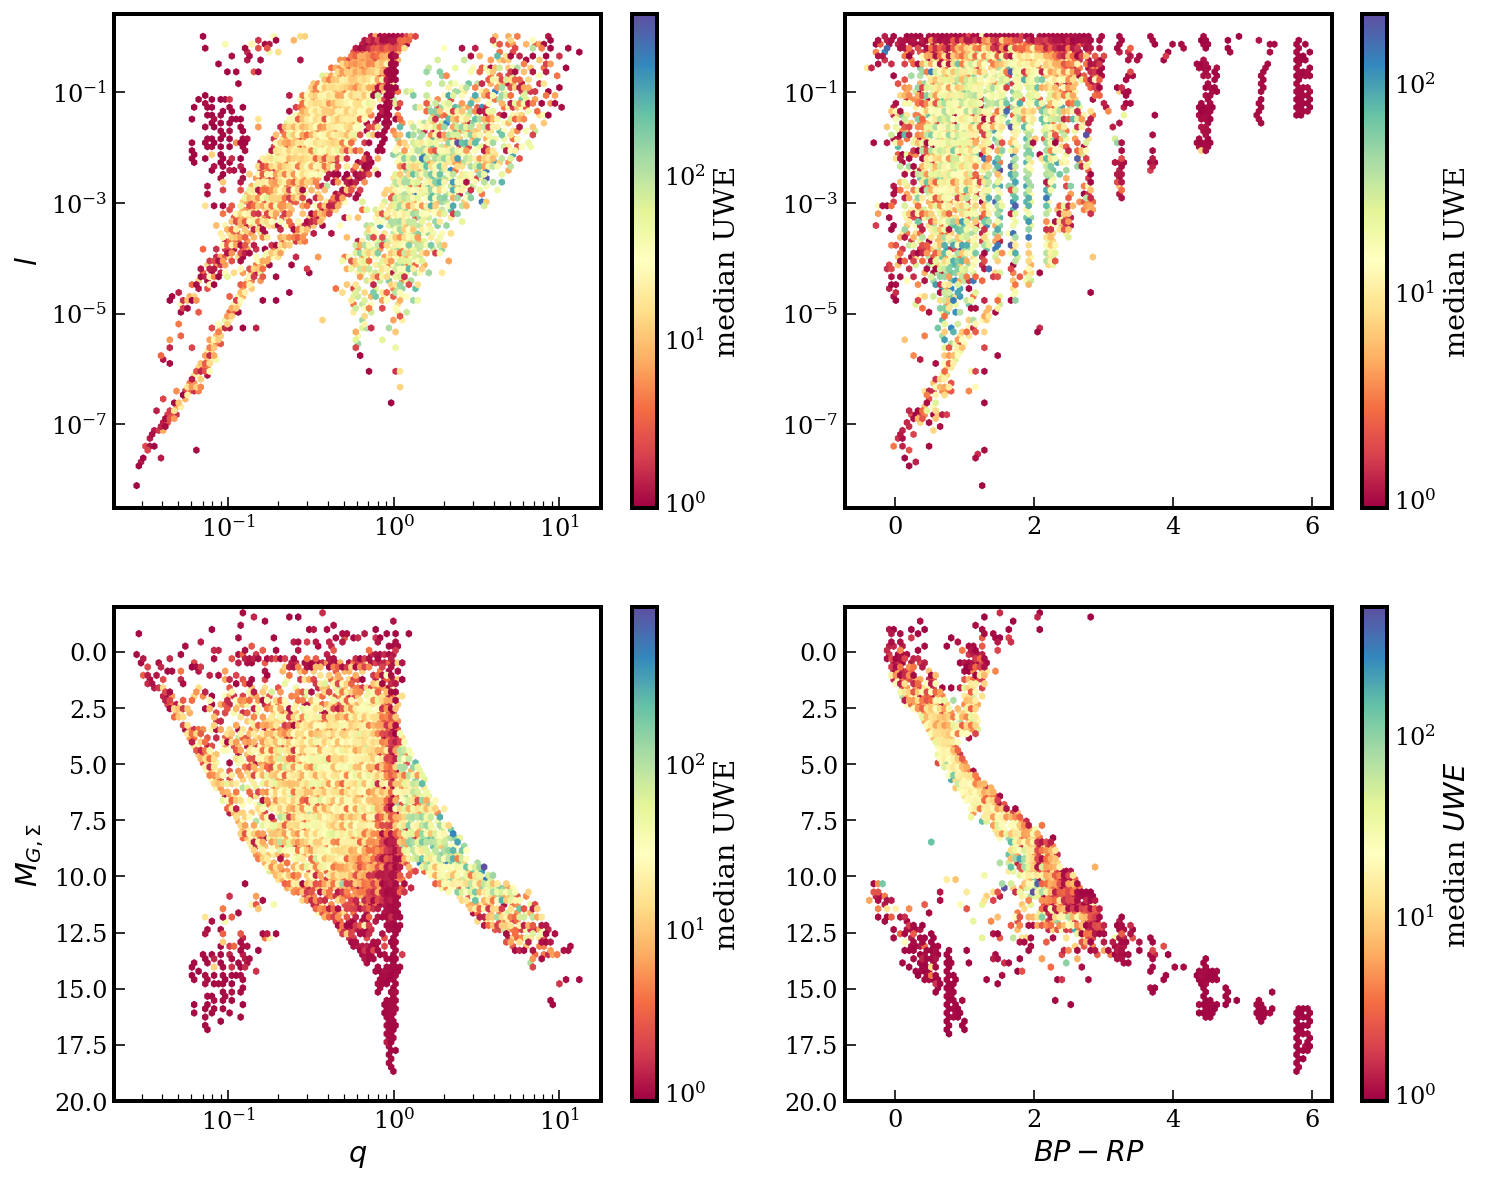

In [47]:
fig=plt.figure(figsize=(12,10))
grid=mpl.gridspec.GridSpec(2,2)

ax=plt.subplot(grid[0,0])
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')


ax=plt.subplot(grid[1,0])
im=ax.hexbin(uqs,uamags,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')
ax.set_ylim(20,-2)
ax.set_ylabel(r'$M_{G,\Sigma}$')
ax.set_xlabel(r'$q$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(ucols,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             yscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')

ax=plt.subplot(grid[1,1])
im=ax.hexbin(ucols,uamags,C=fuwes[fbinaries],reduce_C_function=np.median,
             cmap='Spectral',bins='log')
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(20,-2)
ax.set_xlabel(r'$BP-RP$')
plt.show()

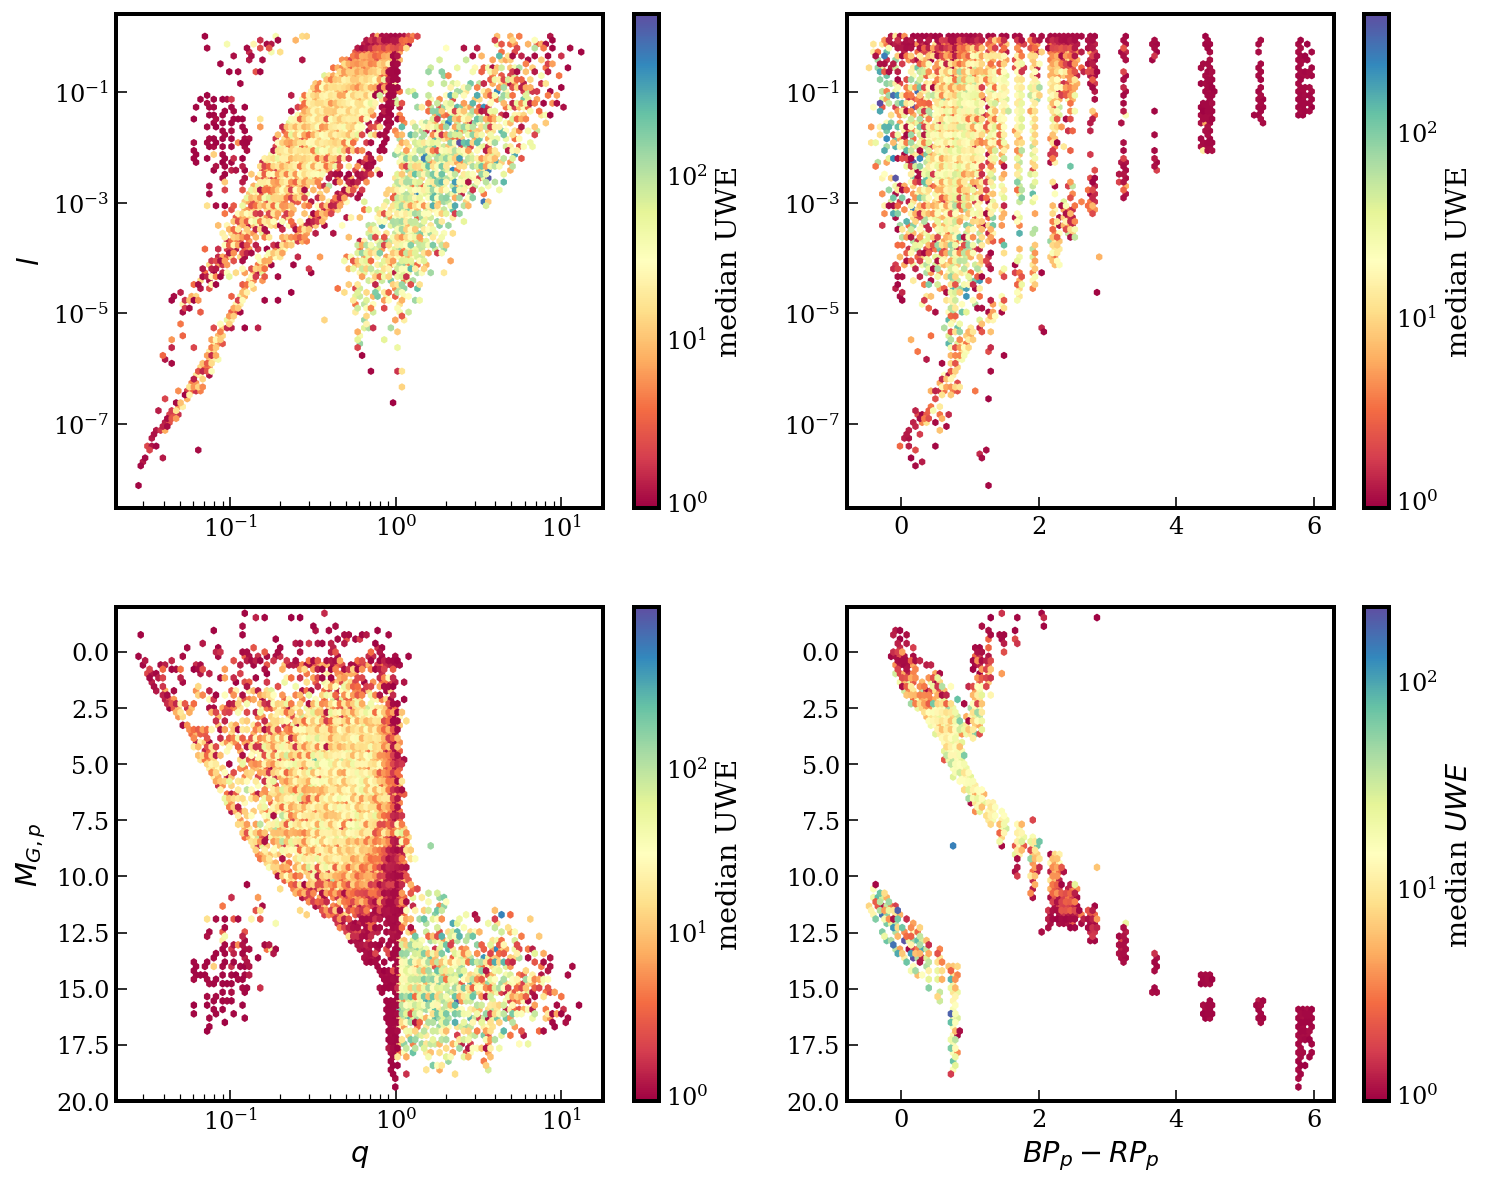

In [48]:
fig=plt.figure(figsize=(12,10))
grid=mpl.gridspec.GridSpec(2,2)

ax=plt.subplot(grid[0,0])
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')


ax=plt.subplot(grid[1,0])
im=ax.hexbin(uqs,aptot_mags[ubins],C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')
ax.set_ylim(20,-2)
ax.set_ylabel(r'$M_{G,p}$')
ax.set_xlabel(r'$q$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(pcols[ubins],uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             yscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')

ax=plt.subplot(grid[1,1])
im=ax.hexbin(pcols[ubins],aptot_mags[ubins],C=fuwes[fbinaries],reduce_C_function=np.median,
             cmap='Spectral',bins='log')
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(20,-2)
ax.set_xlabel(r'$BP_p-RP_p$')
plt.show()

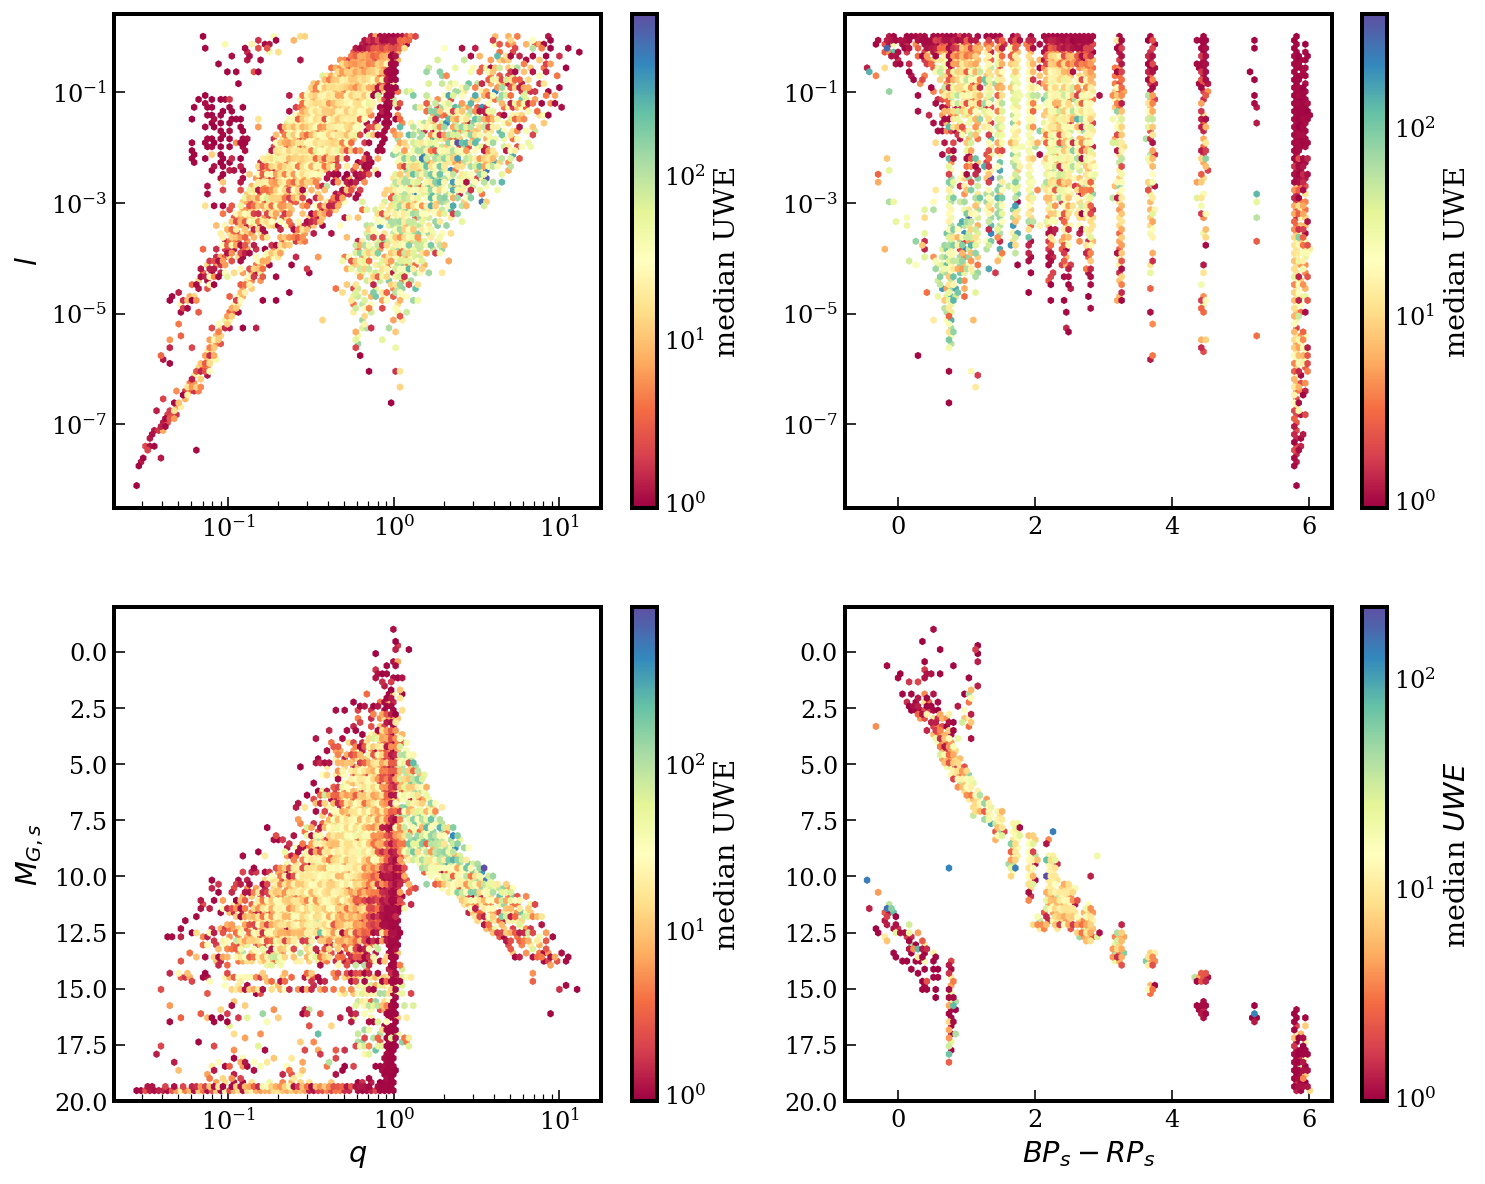

In [53]:
fig=plt.figure(figsize=(12,10))
grid=mpl.gridspec.GridSpec(2,2)

ax=plt.subplot(grid[0,0])
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')


ax=plt.subplot(grid[1,0])
im=ax.hexbin(uqs,astot_mags[ubins],C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')
ax.set_ylim(20,-2)
ax.set_ylabel(r'$M_{G,s}$')
ax.set_xlabel(r'$q$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(scols[ubins],uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             yscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')

ax=plt.subplot(grid[1,1])
im=ax.hexbin(scols[ubins],astot_mags[ubins],C=fuwes[fbinaries],reduce_C_function=np.median,
             cmap='Spectral',bins='log')
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(20,-2)
ax.set_xlabel(r'$BP_{s}-RP_{s}$')
plt.show()

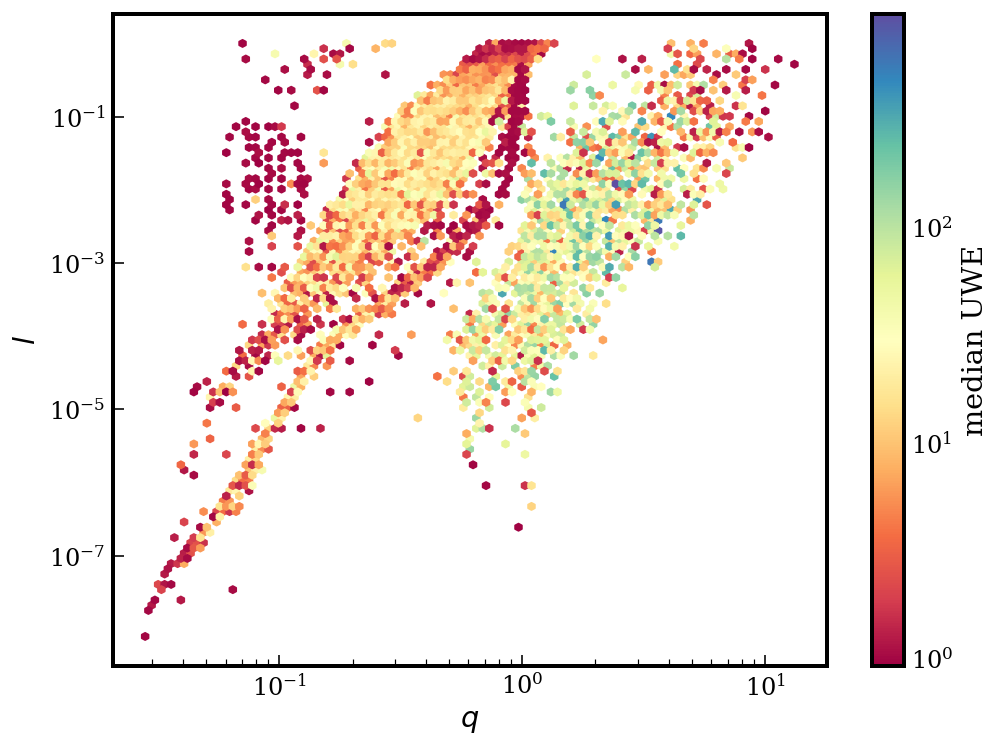

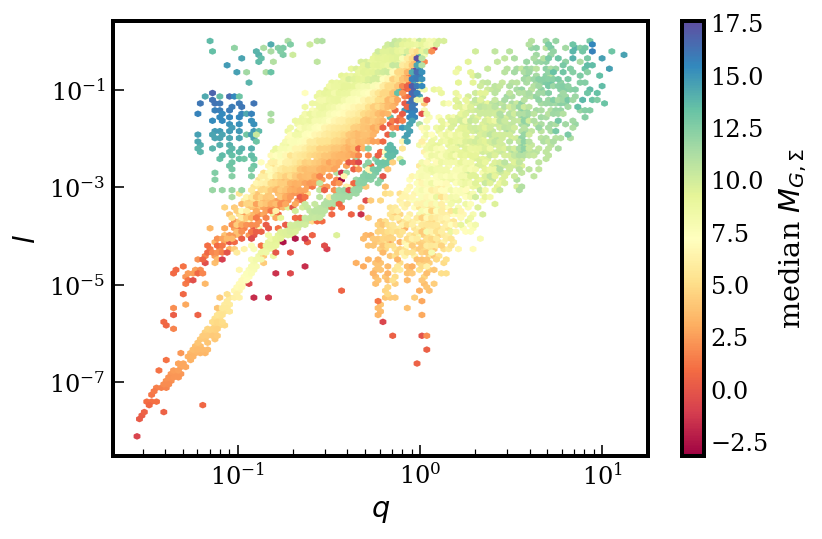

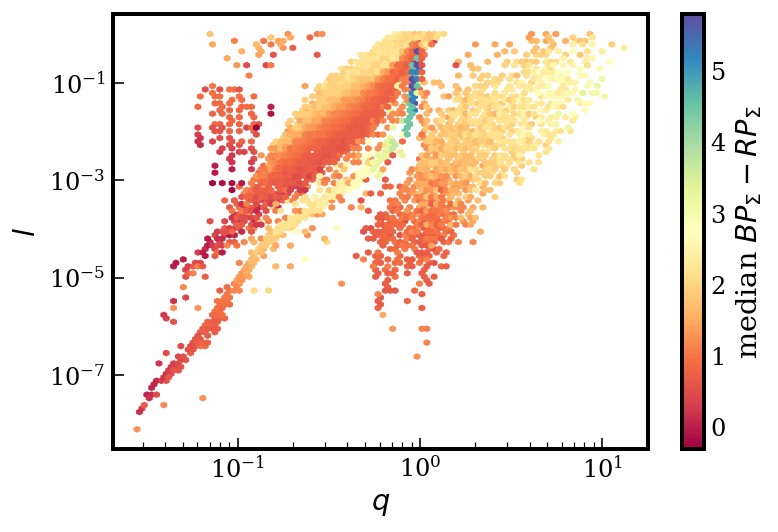

In [54]:
fig=plt.figure(figsize=(8,6))
ax=plt.gca()
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log')
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uqs,uls,C=uamags,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral')
plt.colorbar(im,label='median $M_{G,\Sigma}$')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uqs,uls,C=ucols,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral')
plt.colorbar(im,label='median $BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

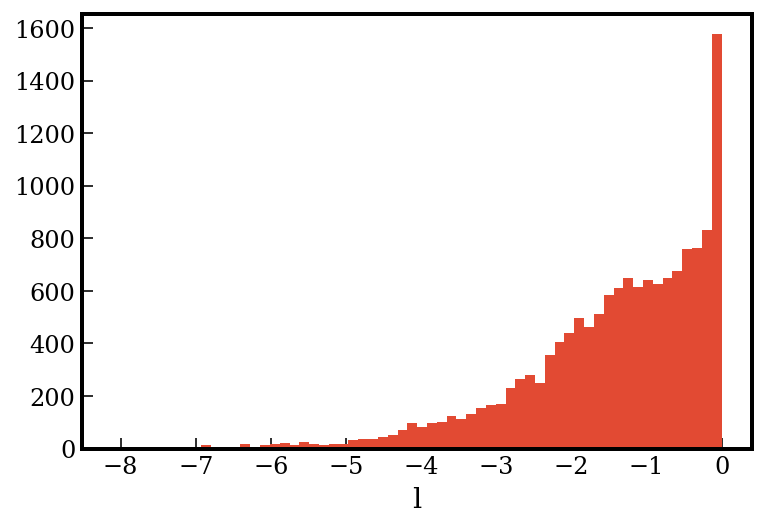

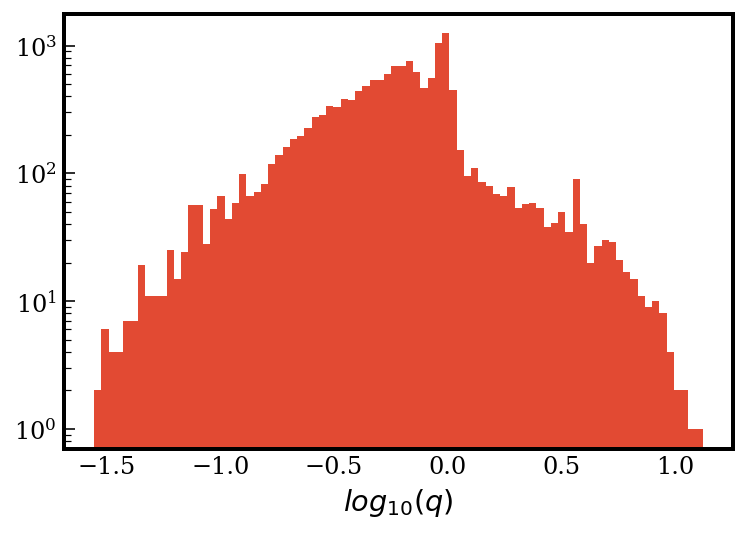

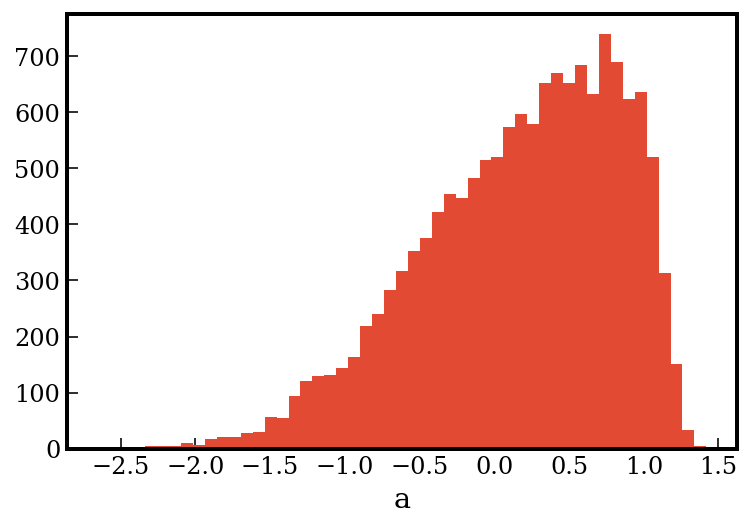

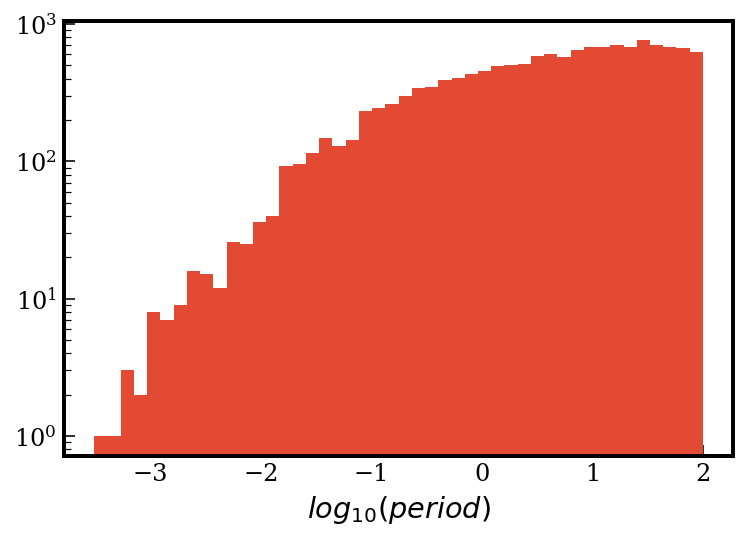

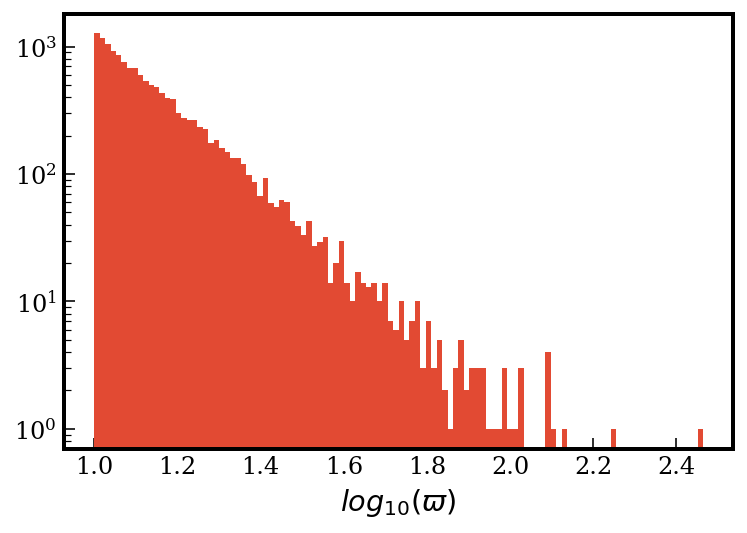

In [55]:
ax=plt.gca()
ax.hist(np.log10(uls),bins='auto')
ax.set_xlabel('l')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uqs),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(q)$')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uas),bins='auto')
ax.set_xlabel('a')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uperiods),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(period)$')
plt.show()

ax=plt.gca()
ax.hist(np.log10(upllxs),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(\varpi)$')
plt.show()

497  interesting sources


  0%|          | 0/497 [00:00<?, ?it/s]

---------------------------------------
ra, dec, pllx, pmrac, pmdec  298.34592102556843 -36.19309976837236 12.178876 4.007511 -97.247375


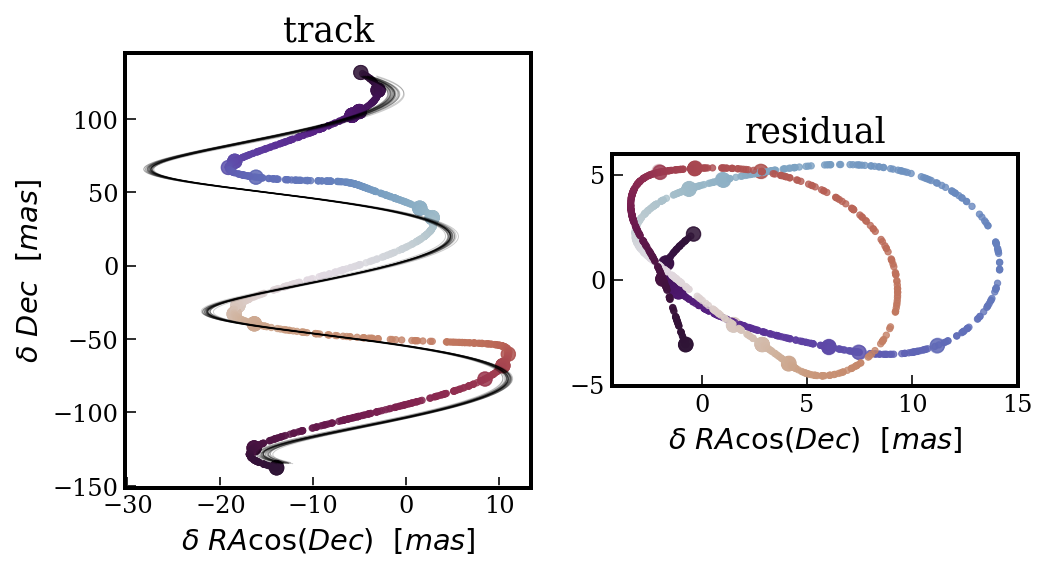

{'astrometric_matched_transits': 32, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 288, 'astrometric_params_solved': 31, 'ra': 298.3458842341382, 'ra_error': 0.18753611515982338, 'dec': -36.19310009545141, 'dec_error': 0.13338314005432791, 'ra_dec_corr': -0.2763640565328444, 'parallax': 14.800442488955653, 'parallax_error': 0.20481758401046063, 'ra_parallax_corr': -0.12769427645477907, 'dec_parallax_corr': 0.24676337701573733, 'pmra': 6.119986961505639, 'pmra_error': 0.2298079372960597, 'ra_pmra_corr': 0.1667672339947171, 'dec_pmra_corr': -0.21292392569950871, 'parallax_pmra_corr': 0.28624587302747084, 'pmdec': -97.06614737967104, 'pmdec_error': 0.14479470167204744, 'ra_pmdec_corr': -0.29908819179597973, 'dec_pmdec_corr': 0.34623170972917705, 'parallax_pmdec_corr': 0.11754422552208992, 'pmra_pmdec_corr': -0.25672544253698126, 'astrometric_excess_noise': 2.678844597873731, 'astrometric_chi2_al': 6919949.016992086, 'astrometric_n_good_obs_al': 288, 'UWE': 156.37172592197274}
---

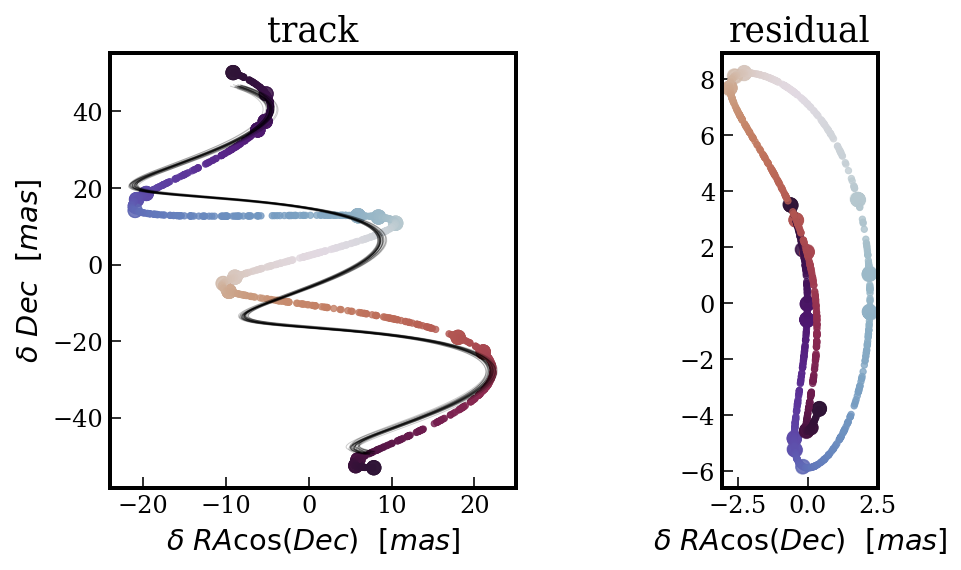

{'astrometric_matched_transits': 35, 'visibility_periods_used': 17, 'astrometric_n_obs_al': 315, 'astrometric_params_solved': 31, 'ra': 303.66890413729743, 'ra_error': 0.17827800470842844, 'dec': -32.247282363857785, 'dec_error': 0.1380586413407947, 'ra_dec_corr': 0.10941840059605486, 'parallax': 11.542914537532766, 'parallax_error': 0.21700013706165303, 'ra_parallax_corr': -0.023630155725193457, 'dec_parallax_corr': 0.16451903951733732, 'pmra': 13.26875001034501, 'pmra_error': 0.2165192032274977, 'ra_pmra_corr': -0.008091909294611033, 'dec_pmra_corr': -0.1631743243805264, 'parallax_pmra_corr': 0.372726999366524, 'pmdec': -34.14705308233547, 'pmdec_error': 0.15536403244489835, 'ra_pmdec_corr': -0.2462395832117855, 'dec_pmdec_corr': 0.0725318094304716, 'parallax_pmdec_corr': 0.10229501551267149, 'pmra_pmdec_corr': 0.11612096562091352, 'astrometric_excess_noise': 3.360994780694885, 'astrometric_chi2_al': 12980477.569293682, 'astrometric_n_good_obs_al': 315, 'UWE': 204.62773098493795}
---

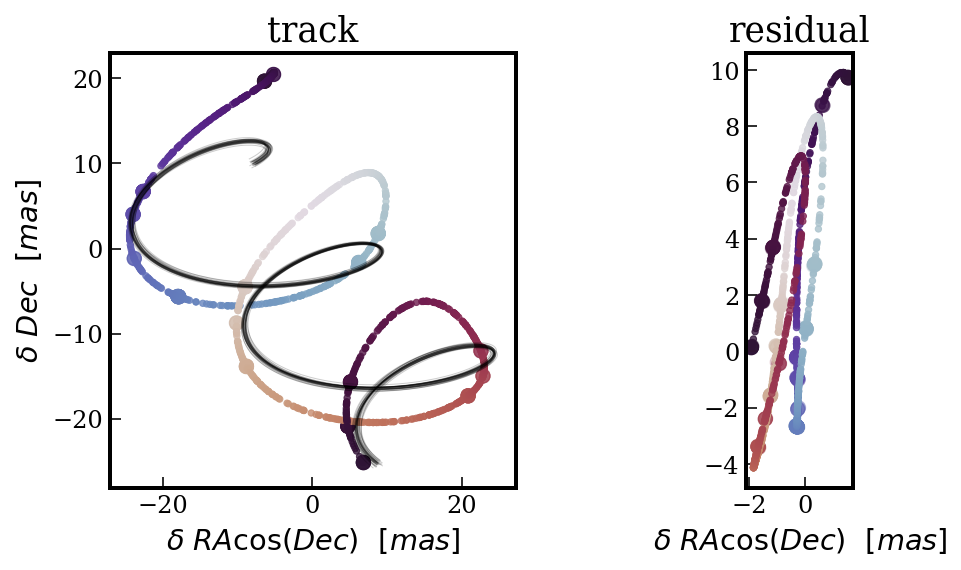

{'astrometric_matched_transits': 34, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 306, 'astrometric_params_solved': 31, 'ra': 292.00897867560366, 'ra_error': 0.13270791988640637, 'dec': 0.2827155834006274, 'dec_error': 0.11036389161332566, 'ra_dec_corr': 0.16836097876865047, 'parallax': 12.714825407201813, 'parallax_error': 0.16286236221316747, 'ra_parallax_corr': 0.2438266254131669, 'dec_parallax_corr': 0.22380776191622287, 'pmra': 15.041923045261168, 'pmra_error': 0.15991653363710032, 'ra_pmra_corr': -0.018059204868656073, 'dec_pmra_corr': -0.15467430448847524, 'parallax_pmra_corr': 0.147834699293073, 'pmdec': -12.016822113891974, 'pmdec_error': 0.1349851984331019, 'ra_pmdec_corr': -0.15345536665795956, 'dec_pmdec_corr': -0.04136896595058641, 'parallax_pmdec_corr': 0.1453948741560848, 'pmra_pmdec_corr': 0.12403353327962231, 'astrometric_excess_noise': 1.8891737318450035, 'astrometric_chi2_al': 3576940.804440582, 'astrometric_n_good_obs_al': 306, 'UWE': 109.0115785925718}
--

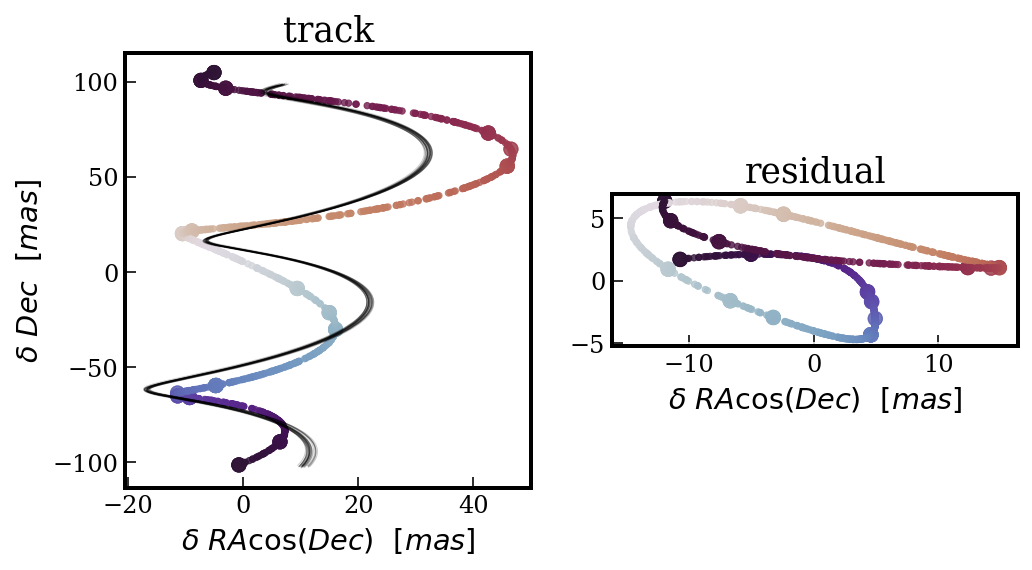

{'astrometric_matched_transits': 37, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 333, 'astrometric_params_solved': 31, 'ra': 289.2060350388506, 'ra_error': 0.2142200048541383, 'dec': 3.6328660746528207, 'dec_error': 0.21333849704208957, 'ra_dec_corr': 0.287295174012238, 'parallax': 16.707176768557304, 'parallax_error': 0.2632744641198381, 'ra_parallax_corr': 0.08959473991728216, 'dec_parallax_corr': 0.21773290547999152, 'pmra': 10.33817964079271, 'pmra_error': 0.2651820170520084, 'ra_pmra_corr': 0.020157226021746577, 'dec_pmra_corr': -0.14099721725809472, 'parallax_pmra_corr': 0.1839595014481371, 'pmdec': 78.33082026262329, 'pmdec_error': 0.24079759371062162, 'ra_pmdec_corr': -0.17560053366816408, 'dec_pmdec_corr': -0.041991204598971515, 'parallax_pmdec_corr': 0.047350476912698544, 'pmra_pmdec_corr': 0.24087370328134222, 'astrometric_excess_noise': 6.555678289723981, 'astrometric_chi2_al': 61404294.02431025, 'astrometric_n_good_obs_al': 333, 'UWE': 432.6756446678629}
-------

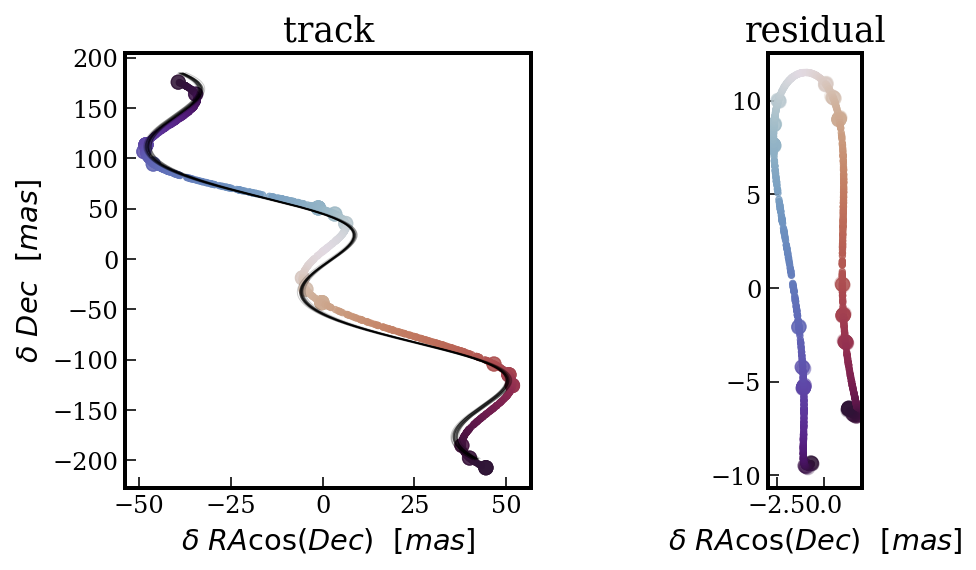

{'astrometric_matched_transits': 24, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 216, 'astrometric_params_solved': 31, 'ra': 290.8478392754916, 'ra_error': 0.2704337019199468, 'dec': -13.127635872719308, 'dec_error': 0.22910088815620547, 'ra_dec_corr': -0.007014592591742913, 'parallax': 16.223263033036186, 'parallax_error': 0.3086426266033254, 'ra_parallax_corr': -0.08532689112217479, 'dec_parallax_corr': 0.404741803523187, 'pmra': 41.89050221693187, 'pmra_error': 0.32380656631408394, 'ra_pmra_corr': -0.1704375645576645, 'dec_pmra_corr': -0.08700947910912589, 'parallax_pmra_corr': 0.11035916720990675, 'pmdec': -144.31122272655227, 'pmdec_error': 0.24936933081901194, 'ra_pmdec_corr': -0.13684572269332887, 'dec_pmdec_corr': -0.1506298587351657, 'parallax_pmdec_corr': -0.07701251155510926, 'pmra_pmdec_corr': 0.032341421426946626, 'astrometric_excess_noise': 5.669498046825757, 'astrometric_chi2_al': 3502263.739323683, 'astrometric_n_good_obs_al': 216, 'UWE': 128.83480254770294}


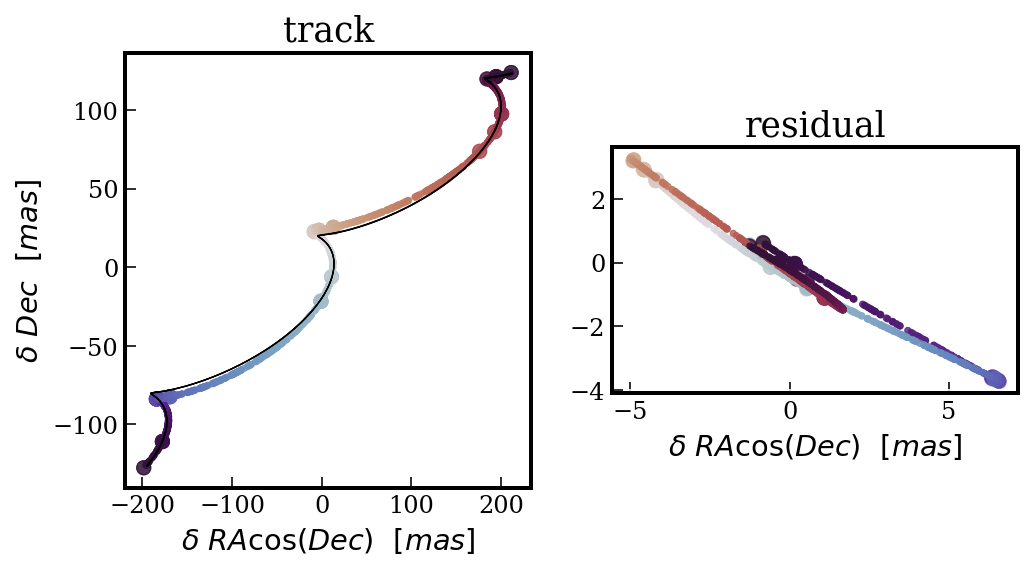

{'astrometric_matched_transits': 27, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 243, 'astrometric_params_solved': 31, 'ra': 290.8796966067465, 'ra_error': 0.11930484904970934, 'dec': -4.834310612724747, 'dec_error': 0.11437768575951394, 'ra_dec_corr': -0.19494715832023066, 'parallax': 45.02630266714841, 'parallax_error': 0.14999928594419337, 'ra_parallax_corr': -0.14719515642473885, 'dec_parallax_corr': 0.4807512593673829, 'pmra': 186.04376133619516, 'pmra_error': 0.14050095913206576, 'ra_pmra_corr': -0.14399384148994968, 'dec_pmra_corr': 0.2144656346224539, 'parallax_pmra_corr': 0.3281500203933704, 'pmdec': 100.02913667777793, 'pmdec_error': 0.12313112138348466, 'ra_pmdec_corr': 0.06278861925048895, 'dec_pmdec_corr': -0.07622636589655833, 'parallax_pmdec_corr': -0.15194640598917766, 'pmra_pmdec_corr': 0.11987132684139763, 'astrometric_excess_noise': 1.2147359362958348, 'astrometric_chi2_al': 3577429.3952234383, 'astrometric_n_good_obs_al': 225, 'UWE': 127.5187935386823}
--

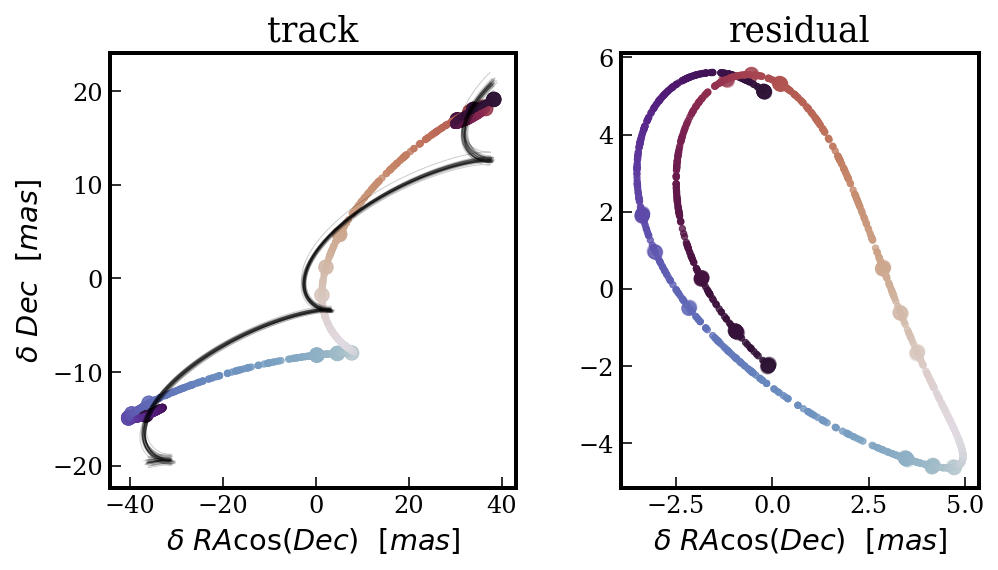

{'astrometric_matched_transits': 25, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 225, 'astrometric_params_solved': 31, 'ra': 289.68959851232006, 'ra_error': 0.18523814537527605, 'dec': -35.806509004638954, 'dec_error': 0.17132999801831533, 'ra_dec_corr': 0.08764724846171622, 'parallax': 9.899178185652556, 'parallax_error': 0.21796434168298787, 'ra_parallax_corr': -0.007347219120337491, 'dec_parallax_corr': 0.33396561305253886, 'pmra': 34.37753710699474, 'pmra_error': 0.22099379321584922, 'ra_pmra_corr': -0.19824441620269015, 'dec_pmra_corr': -0.07619849261890878, 'parallax_pmra_corr': 0.26700989406751957, 'pmdec': 16.065486160234208, 'pmdec_error': 0.18570079172068482, 'ra_pmdec_corr': -0.17875842165504222, 'dec_pmdec_corr': -0.27900663921859936, 'parallax_pmdec_corr': -0.049767254572149026, 'pmra_pmdec_corr': 0.11023470565239266, 'astrometric_excess_noise': 3.0431000179583703, 'astrometric_chi2_al': 4880938.535173852, 'astrometric_n_good_obs_al': 225, 'UWE': 148.94993874047

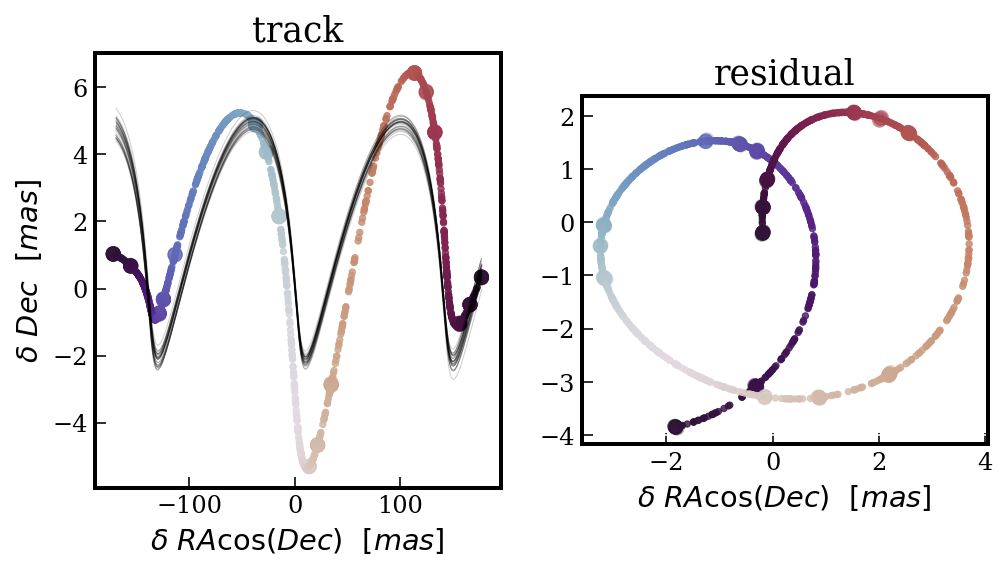

{'astrometric_matched_transits': 30, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 270, 'astrometric_params_solved': 31, 'ra': 294.7673837489408, 'ra_error': 0.1239867169629052, 'dec': -31.670807809732402, 'dec_error': 0.12580114274578727, 'ra_dec_corr': 0.36412861259295015, 'parallax': 14.606005906215362, 'parallax_error': 0.14511778437816586, 'ra_parallax_corr': 0.09651253704332978, 'dec_parallax_corr': 0.3834413605115878, 'pmra': 140.03854323069686, 'pmra_error': 0.14284544549305062, 'ra_pmra_corr': -0.1660293543422998, 'dec_pmra_corr': -0.19843865922773196, 'parallax_pmra_corr': 0.22652041227475372, 'pmdec': -0.04068898959015854, 'pmdec_error': 0.13135128944866123, 'ra_pmdec_corr': -0.323040097220784, 'dec_pmdec_corr': -0.31898414177609735, 'parallax_pmdec_corr': -0.046580150897418154, 'pmra_pmdec_corr': 0.31588123370167026, 'astrometric_excess_noise': 1.5523072395757394, 'astrometric_chi2_al': 2833945.049831738, 'astrometric_n_good_obs_al': 270, 'UWE': 103.41243766354216}

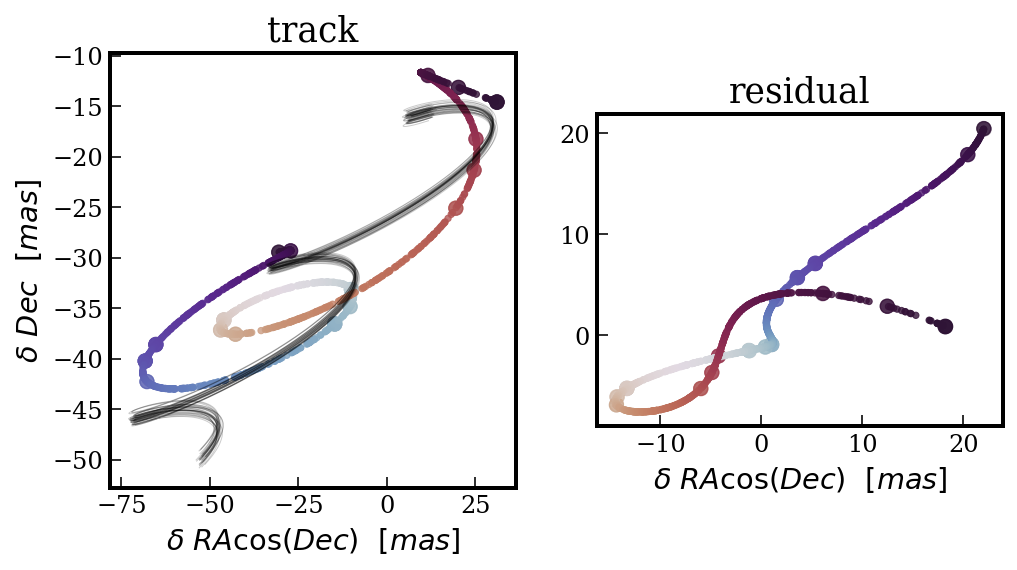

{'astrometric_matched_transits': 23, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 207, 'astrometric_params_solved': 31, 'ra': 288.9282565470603, 'ra_error': 0.2916475585804561, 'dec': -16.793170746401888, 'dec_error': 0.2625554386209567, 'ra_dec_corr': 0.148932276921756, 'parallax': 20.834376448291593, 'parallax_error': 0.33680212919537356, 'ra_parallax_corr': 0.06663689133376481, 'dec_parallax_corr': 0.39118543299942526, 'pmra': 38.68255505317059, 'pmra_error': 0.36467848172720996, 'ra_pmra_corr': -0.02204127869320029, 'dec_pmra_corr': -0.17554606308780457, 'parallax_pmra_corr': 0.12586872141248773, 'pmdec': 14.914923730986471, 'pmdec_error': 0.2889350833293756, 'ra_pmdec_corr': -0.24278170083405787, 'dec_pmdec_corr': -0.13778597893909045, 'parallax_pmdec_corr': -0.028974310636602392, 'pmra_pmdec_corr': 0.09648552237476885, 'astrometric_excess_noise': 6.596232523901523, 'astrometric_chi2_al': 16774058.774770506, 'astrometric_n_good_obs_al': 207, 'UWE': 288.16643615210717}
--

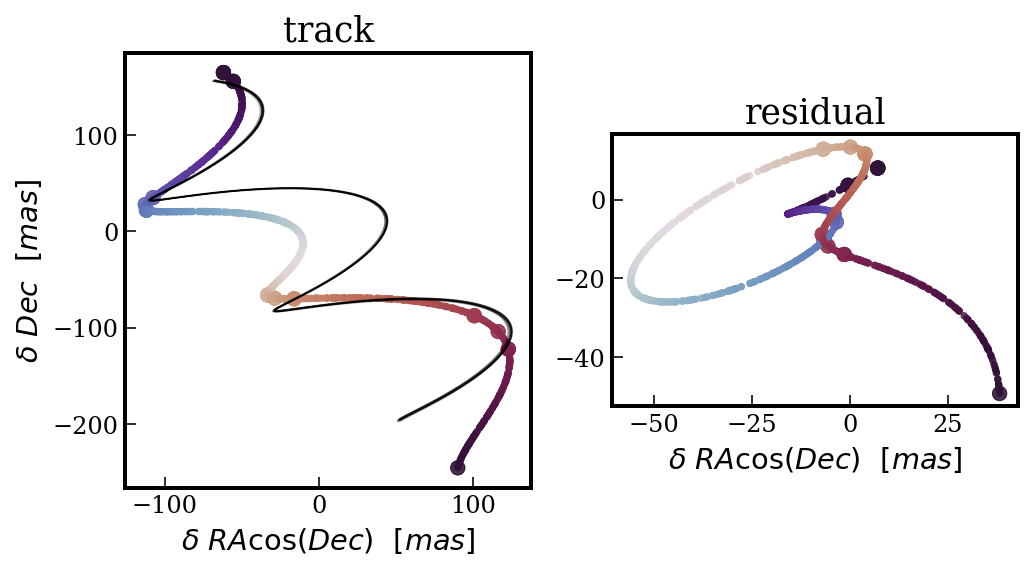

{'astrometric_matched_transits': 20, 'visibility_periods_used': 11, 'astrometric_n_obs_al': 180, 'astrometric_params_solved': 31, 'ra': 356.6191043422928, 'ra_error': 0.3605558057154751, 'dec': -19.76383146186036, 'dec_error': 0.3350680029964886, 'ra_dec_corr': 0.09940825652659678, 'parallax': 59.568759671040176, 'parallax_error': 0.46256696972440703, 'ra_parallax_corr': -0.035478471858684094, 'dec_parallax_corr': 0.427284756630525, 'pmra': 80.50486006670064, 'pmra_error': 0.4190289767377733, 'ra_pmra_corr': -0.05566056884108688, 'dec_pmra_corr': -0.07900895693220995, 'parallax_pmra_corr': -0.15336350313266822, 'pmdec': -114.99656079299555, 'pmdec_error': 0.4069943760452163, 'ra_pmdec_corr': -0.06343060694742508, 'dec_pmdec_corr': 0.18501128088503138, 'parallax_pmdec_corr': 0.22434930333309583, 'pmra_pmdec_corr': 0.29045056270095937, 'astrometric_excess_noise': 9.062392164973401, 'astrometric_chi2_al': 60851860.61231644, 'astrometric_n_good_obs_al': 180, 'UWE': 589.6820480434056}
-----

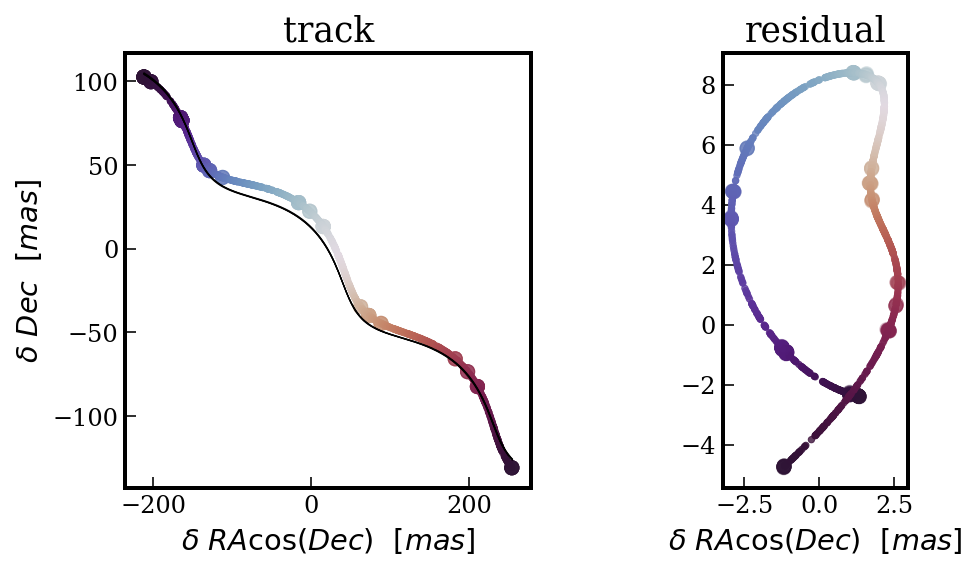

{'astrometric_matched_transits': 36, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 324, 'astrometric_params_solved': 31, 'ra': 0.5098596405217969, 'ra_error': 0.1629792756903647, 'dec': -18.800986033932812, 'dec_error': 0.14157492838296865, 'ra_dec_corr': 0.16011479682094598, 'parallax': 15.188137520316502, 'parallax_error': 0.21587781436319814, 'ra_parallax_corr': -0.10354844609878228, 'dec_parallax_corr': 0.29552102481752934, 'pmra': 190.46313976093714, 'pmra_error': 0.21043699484510678, 'ra_pmra_corr': 0.12859519977415684, 'dec_pmra_corr': -0.03936778772748857, 'parallax_pmra_corr': -0.020856313846064182, 'pmdec': -84.13634190385571, 'pmdec_error': 0.15638627656007864, 'ra_pmdec_corr': -0.037010932425154554, 'dec_pmdec_corr': 0.4949169018955809, 'parallax_pmdec_corr': 0.3818341802549789, 'pmra_pmdec_corr': 0.14418442446658553, 'astrometric_excess_noise': 2.8043582572816237, 'astrometric_chi2_al': 5762165.953912035, 'astrometric_n_good_obs_al': 324, 'UWE': 134.39946486673247

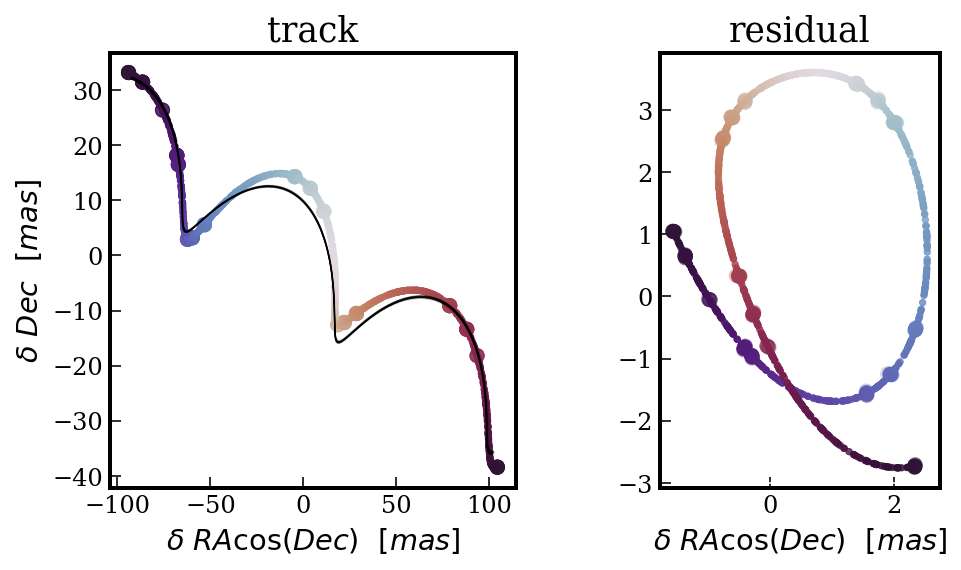

{'astrometric_matched_transits': 33, 'visibility_periods_used': 17, 'astrometric_n_obs_al': 297, 'astrometric_params_solved': 31, 'ra': 1.4799009217335912, 'ra_error': 0.11279308235651583, 'dec': -30.871168406451787, 'dec_error': 0.09925492676729182, 'ra_dec_corr': -0.027979333284184275, 'parallax': 13.608422519929471, 'parallax_error': 0.1309572922805015, 'ra_parallax_corr': -0.17011057334700597, 'dec_parallax_corr': 0.2010207638590027, 'pmra': 81.87566748532855, 'pmra_error': 0.14944871295510387, 'ra_pmra_corr': 0.16197751425209891, 'dec_pmra_corr': -0.06423809884670163, 'parallax_pmra_corr': -0.01649604706931614, 'pmdec': -20.06775003106251, 'pmdec_error': 0.11341308757411626, 'ra_pmdec_corr': -0.0872078925748258, 'dec_pmdec_corr': 0.21204095402368828, 'parallax_pmdec_corr': 0.2149593969428586, 'pmra_pmdec_corr': -0.05297034942992075, 'astrometric_excess_noise': 1.5357878516507024, 'astrometric_chi2_al': 3140323.063322187, 'astrometric_n_good_obs_al': 297, 'UWE': 103.7040550739199}


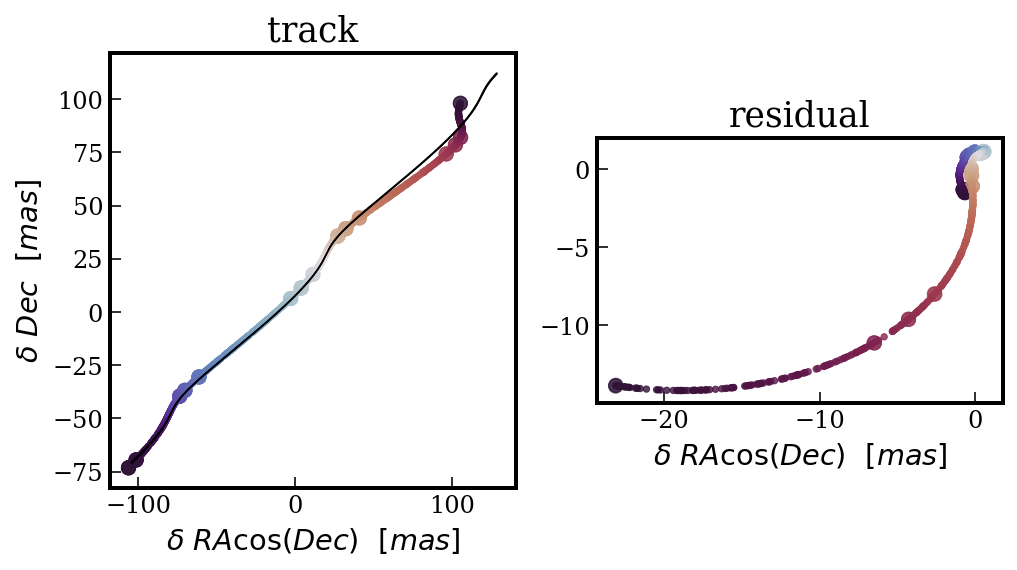

{'astrometric_matched_transits': 23, 'visibility_periods_used': 14, 'astrometric_n_obs_al': 207, 'astrometric_params_solved': 31, 'ra': 352.0359527872275, 'ra_error': 0.13548810428108404, 'dec': 1.8447707256653154, 'dec_error': 0.1248342085517927, 'ra_dec_corr': 0.18840654903294696, 'parallax': 11.594347241462472, 'parallax_error': 0.15164629938419197, 'ra_parallax_corr': 0.09550351914741503, 'dec_parallax_corr': 0.2662526474266289, 'pmra': 98.7741685205843, 'pmra_error': 0.20851567867274792, 'ra_pmra_corr': 0.01218950044867188, 'dec_pmra_corr': 0.1818675716151939, 'parallax_pmra_corr': -0.0032555861190804187, 'pmdec': 74.66079763126668, 'pmdec_error': 0.18147828494086624, 'ra_pmdec_corr': 0.11543023781891101, 'dec_pmdec_corr': 0.5449817880489433, 'parallax_pmdec_corr': 0.2370204061860114, 'pmra_pmdec_corr': 0.335495191846349, 'astrometric_excess_noise': 1.1291725695306292, 'astrometric_chi2_al': 15781191.969211496, 'astrometric_n_good_obs_al': 189, 'UWE': 292.86062838619694}
---------

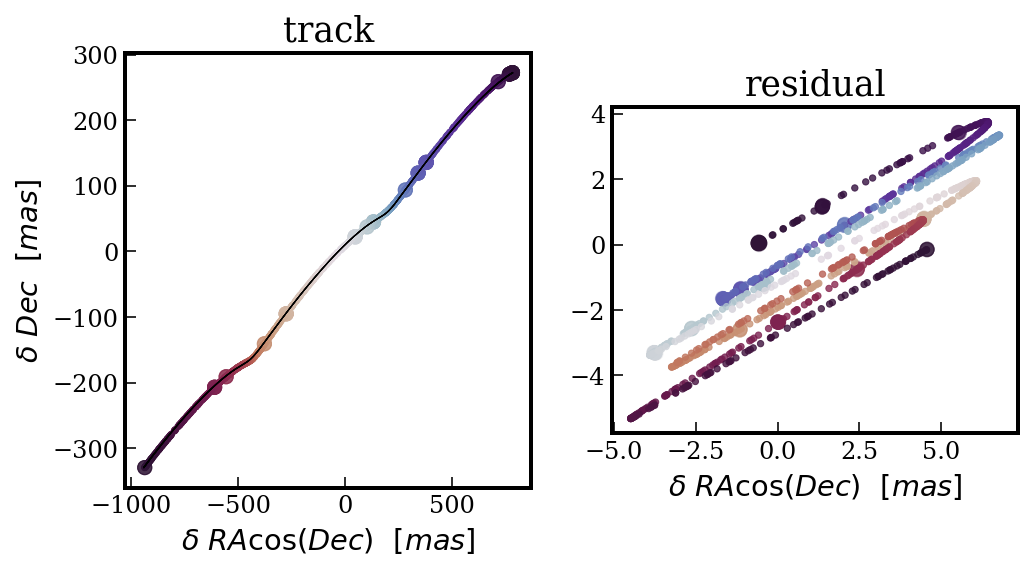

{'astrometric_matched_transits': 25, 'visibility_periods_used': 13, 'astrometric_n_obs_al': 225, 'astrometric_params_solved': 31, 'ra': 351.5717126805389, 'ra_error': 0.1650863862672101, 'dec': 5.695579508302088, 'dec_error': 0.1268405713969052, 'ra_dec_corr': -0.046763616474564465, 'parallax': 59.35096386440742, 'parallax_error': 0.1977926408710739, 'ra_parallax_corr': -0.39335483207074046, 'dec_parallax_corr': 0.3616797244484274, 'pmra': -639.6051729180674, 'pmra_error': 0.1979225653184787, 'ra_pmra_corr': 0.16509173702605118, 'dec_pmra_corr': -0.20360113545030742, 'parallax_pmra_corr': -0.11751005491266034, 'pmdec': -224.19237130263562, 'pmdec_error': 0.14765235733495913, 'ra_pmdec_corr': -0.254643395510102, 'dec_pmdec_corr': 0.36075471535767484, 'parallax_pmdec_corr': 0.2859342265076584, 'pmra_pmdec_corr': 0.10598199725374959, 'astrometric_excess_noise': 1.667810813616269, 'astrometric_chi2_al': 2251017.4982974157, 'astrometric_n_good_obs_al': 225, 'UWE': 101.15284335862096}
------

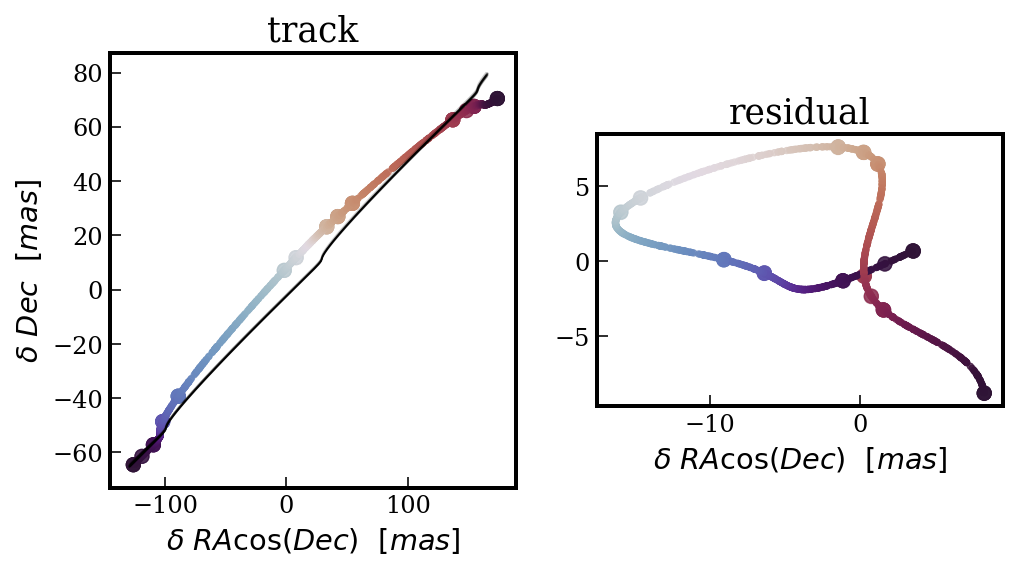

{'astrometric_matched_transits': 24, 'visibility_periods_used': 13, 'astrometric_n_obs_al': 216, 'astrometric_params_solved': 31, 'ra': 348.19320470275704, 'ra_error': 0.23272014335111998, 'dec': -7.494988069372235, 'dec_error': 0.20350432733671836, 'ra_dec_corr': -0.022926587487479697, 'parallax': 20.74885821951232, 'parallax_error': 0.27607518512909895, 'ra_parallax_corr': -0.20574913262880232, 'dec_parallax_corr': 0.4638231516677371, 'pmra': 128.47825544110117, 'pmra_error': 0.2611863044087932, 'ra_pmra_corr': -0.15820187904181038, 'dec_pmra_corr': -0.012166513911155094, 'parallax_pmra_corr': 0.17987390998750433, 'pmdec': 62.27151510471414, 'pmdec_error': 0.22272427731414512, 'ra_pmdec_corr': -0.14258280892977612, 'dec_pmdec_corr': -0.04773726319184172, 'parallax_pmdec_corr': 0.1523491837788211, 'pmra_pmdec_corr': 0.21383380075092975, 'astrometric_excess_noise': 4.068589912833327, 'astrometric_chi2_al': 12054084.526292939, 'astrometric_n_good_obs_al': 216, 'UWE': 239.01540260797586}

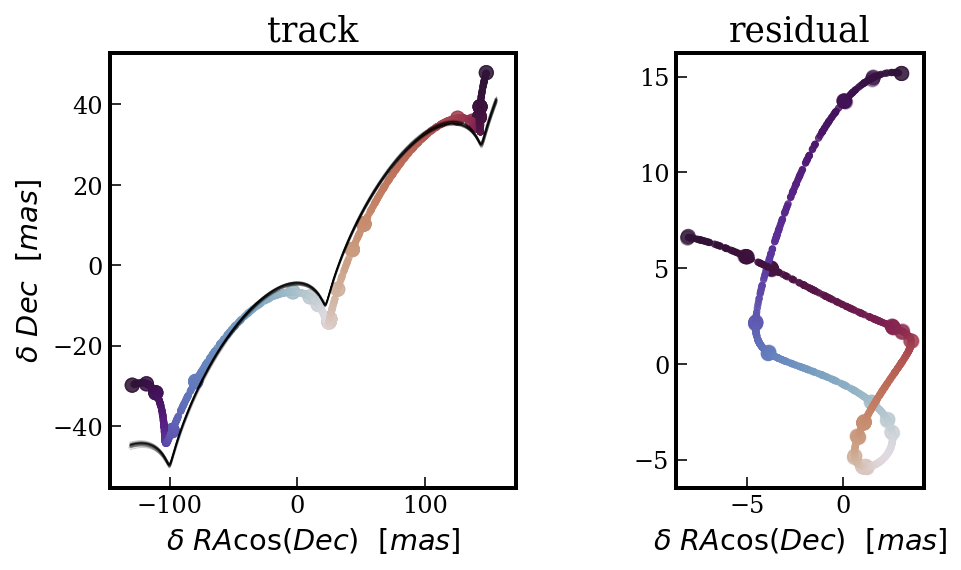

{'astrometric_matched_transits': 33, 'visibility_periods_used': 18, 'astrometric_n_obs_al': 297, 'astrometric_params_solved': 31, 'ra': 341.80153772243114, 'ra_error': 0.18104462121781698, 'dec': -38.56401302313627, 'dec_error': 0.2031316656778129, 'ra_dec_corr': 0.1748618214269915, 'parallax': 17.309622197537195, 'parallax_error': 0.2766522046114113, 'ra_parallax_corr': -0.009075750188884128, 'dec_parallax_corr': 0.45675128656294794, 'pmra': 122.14138242061762, 'pmra_error': 0.25500310193543013, 'ra_pmra_corr': -0.27015195236284006, 'dec_pmra_corr': 0.13524791518326348, 'parallax_pmra_corr': 0.3564934657711734, 'pmdec': 39.86776954828494, 'pmdec_error': 0.23611895044181938, 'ra_pmdec_corr': -0.029865390290356474, 'dec_pmdec_corr': -0.3448196067098773, 'parallax_pmdec_corr': -0.06960485833071993, 'pmra_pmdec_corr': 0.20788136532298737, 'astrometric_excess_noise': 4.021630071079057, 'astrometric_chi2_al': 4786093.3072797, 'astrometric_n_good_obs_al': 297, 'UWE': 128.02628833322686}
----

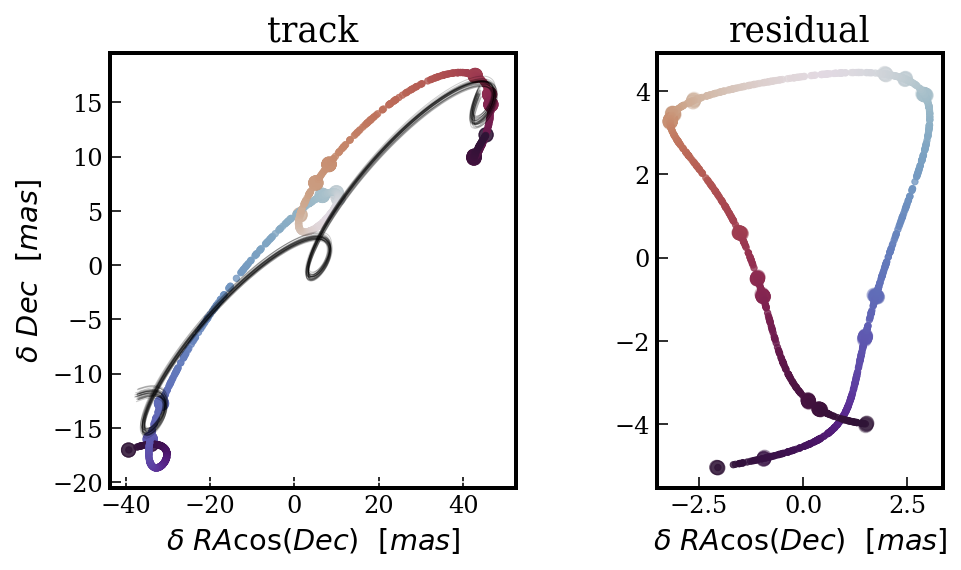

{'astrometric_matched_transits': 27, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 243, 'astrometric_params_solved': 31, 'ra': 333.8885010955175, 'ra_error': 0.17372421383532705, 'dec': -25.983067570364003, 'dec_error': 0.15823130018528614, 'ra_dec_corr': 0.15467225697878914, 'parallax': 11.107223535050027, 'parallax_error': 0.19114997036474093, 'ra_parallax_corr': -0.05587268688142475, 'dec_parallax_corr': 0.1086909075050765, 'pmra': 39.06070120977727, 'pmra_error': 0.2099137356845879, 'ra_pmra_corr': -0.2903783012398698, 'dec_pmra_corr': 0.010630402499164238, 'parallax_pmra_corr': 0.09377528088865363, 'pmdec': 14.281143164466506, 'pmdec_error': 0.1852987870064659, 'ra_pmdec_corr': -0.0028195122918241813, 'dec_pmdec_corr': -0.45559288934565817, 'parallax_pmdec_corr': 0.060270313718924044, 'pmra_pmdec_corr': 0.1845788703938402, 'astrometric_excess_noise': 2.611713339233834, 'astrometric_chi2_al': 3652460.598539946, 'astrometric_n_good_obs_al': 243, 'UWE': 123.88088271847685}
-

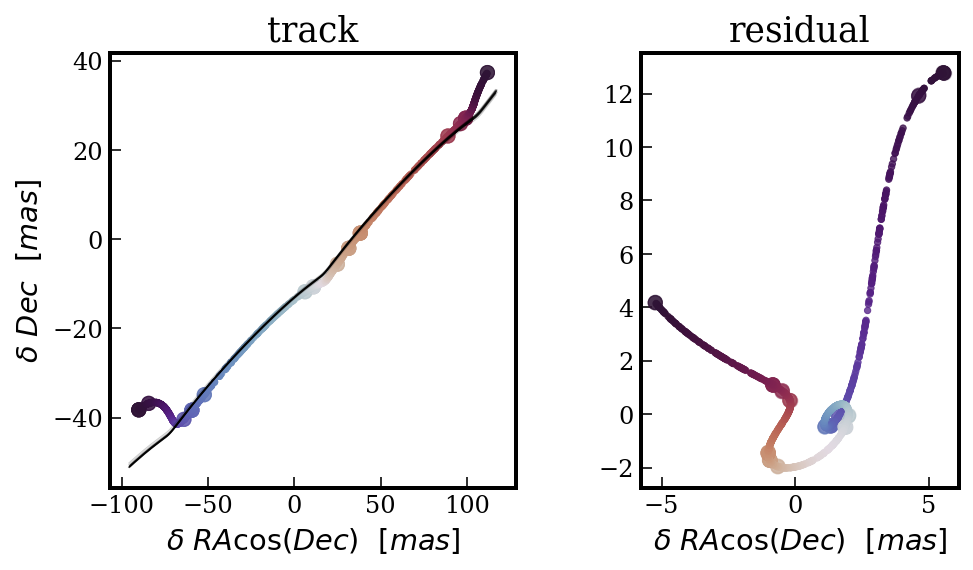

{'astrometric_matched_transits': 20, 'visibility_periods_used': 13, 'astrometric_n_obs_al': 180, 'astrometric_params_solved': 31, 'ra': 341.9936076115741, 'ra_error': 0.14965858826967576, 'dec': -14.319094522859935, 'dec_error': 0.15909069757080763, 'ra_dec_corr': 0.31574436821330343, 'parallax': 9.833673451934155, 'parallax_error': 0.17467057677038283, 'ra_parallax_corr': 0.11791073906861407, 'dec_parallax_corr': 0.3359686911171165, 'pmra': 89.34733570128067, 'pmra_error': 0.19930832262114334, 'ra_pmra_corr': -0.11072610809683475, 'dec_pmra_corr': -0.23381216169061964, 'parallax_pmra_corr': -0.09541055450775263, 'pmdec': 35.746918985581615, 'pmdec_error': 0.20123567315354887, 'ra_pmdec_corr': -0.20144588817193457, 'dec_pmdec_corr': -0.3856601368401756, 'parallax_pmdec_corr': -0.03596641049652076, 'pmra_pmdec_corr': 0.34814381370260356, 'astrometric_excess_noise': 1.6101041505608773, 'astrometric_chi2_al': 6633853.1371491235, 'astrometric_n_good_obs_al': 171, 'UWE': 199.9074053298617}


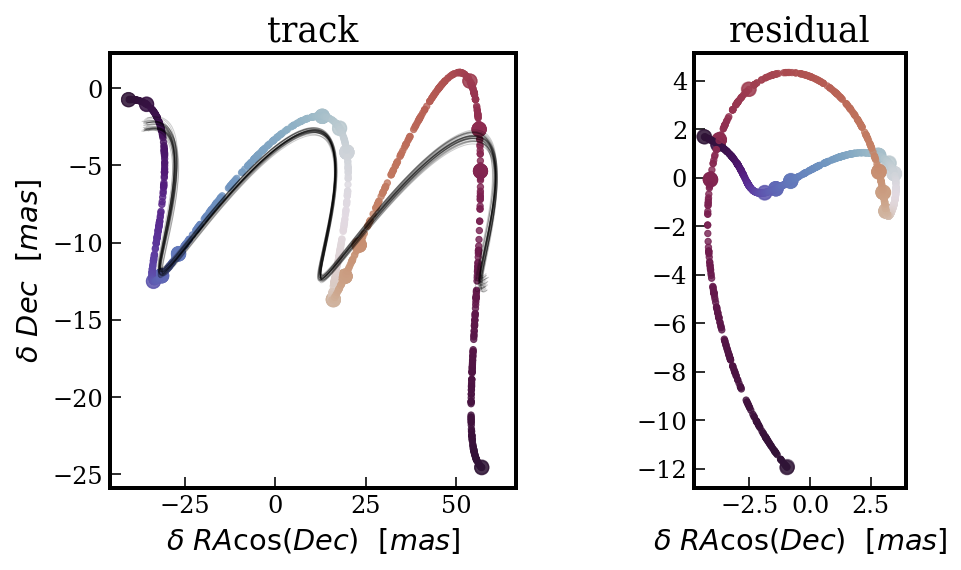

{'astrometric_matched_transits': 24, 'visibility_periods_used': 14, 'astrometric_n_obs_al': 216, 'astrometric_params_solved': 31, 'ra': 340.7629915342912, 'ra_error': 0.1636746379242885, 'dec': -17.061724794833967, 'dec_error': 0.14911987113779748, 'ra_dec_corr': 0.1207647346523454, 'parallax': 11.535361873388329, 'parallax_error': 0.1848938914674249, 'ra_parallax_corr': -0.04846915238274017, 'dec_parallax_corr': 0.21714710488718889, 'pmra': 44.240408688241196, 'pmra_error': 0.2528046198664826, 'ra_pmra_corr': -0.042618210800086036, 'dec_pmra_corr': -0.02192189566733318, 'parallax_pmra_corr': -0.12905587490861073, 'pmdec': -0.41159807346967003, 'pmdec_error': 0.20943390917084947, 'ra_pmdec_corr': 0.00340693015518205, 'dec_pmdec_corr': -0.18134233229994837, 'parallax_pmdec_corr': -0.025332485181578587, 'pmra_pmdec_corr': 0.12261871129175189, 'astrometric_excess_noise': 2.371699438285224, 'astrometric_chi2_al': 8305815.740830143, 'astrometric_n_good_obs_al': 211, 'UWE': 200.7971461139947

KeyboardInterrupt: 

In [67]:
interesting=np.flatnonzero((uperiods<5) & (fuwes[fbinaries]>100))
print(interesting.size,' interesting sources')

for i in tqdm(range(interesting.size)):
    i=interesting[i]
    
    params=astromet.params()
    params.ra=uras[i]
    params.dec=udecs[i]
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]
    
    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    params.parallax=upllxs[i]
    params.pmrac=upmras[i]
    params.pmdec=upmdecs[i]
    
    params.period=uperiods[i]
    params.a=uas[i]
    params.e=ues[i]
    
    params.l=uls[i]
    params.q=uqs[i]
    
    params.vtheta=uvthetas[i]
    params.vphi=uvphis[i]
    params.vomega=uvomegas[i]
    
    params.tperi=utperis[i]
    
    alError=astromet.sigma_ast(umags[i])
    
    trueRacs,trueDecs=astromet.track(ts,params)
    
    t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)
    
    fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)
    results=astromet.gaia_results(fitresults)
    
    #print('mag: ',umags[i])
    print('---------------------------------------')
    print('ra, dec, pllx, pmrac, pmdec ',params.ra,params.dec,params.parallax,params.pmrac,params.pmdec)
    #print(results)
    
     #optionally plot tracks
    plotts=np.sort(ts[0]+(ts[-1]-ts[0])*np.random.rand(1000))
    plotRacs,plotDecs=astromet.track(plotts,params)
    
    fig=plt.figure(figsize=(8,4))
    grid=mpl.gridspec.GridSpec(1,2)
    ax=plt.subplot(grid[0,0])
    ax.set_title('track')
    fitparams=astromet.params()
    for i in range(32):
        fitparams.ra=params.ra
        fitparams.dec=params.dec
        fitparams.drac=fitresults['drac']+np.random.randn()*fitresults['drac_error']
        fitparams.ddec=fitresults['ddec']+np.random.randn()*fitresults['ddec_error']
        fitparams.pmrac=fitresults['pmrac']+np.random.randn()*fitresults['pmrac_error']
        fitparams.pmdec=fitresults['pmdec']+np.random.randn()*fitresults['pmdec_error']
        fitparams.parallax=fitresults['parallax']+np.random.randn()*fitresults['parallax_error']
        
        fitRacs,fitDecs=astromet.track(plotts,fitparams)
        ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
    ax.scatter(rac_obs,dec_obs,c=t_obs,alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs,plotDecs,c=plotts,s=10,alpha=0.8,cmap='twilight_shifted')
    ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
    ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')
    
    ax=plt.subplot(grid[0,1])
    ax.set_title('residual')
    bestparams=astromet.params()
    bestparams.ra=params.ra
    bestparams.dec=params.dec
    bestparams.drac=fitresults['drac']
    bestparams.ddec=fitresults['ddec']
    bestparams.pmrac=fitresults['pmrac']
    bestparams.pmdec=fitresults['pmdec']
    bestparams.parallax=fitresults['parallax']
    bestRacs,bestDecs=astromet.track(plotts,bestparams)
    bestRac_obs,bestDec_obs=astromet.track(t_obs,bestparams)
    
    ax.scatter(rac_obs-bestRac_obs,dec_obs-bestDec_obs,c=t_obs,
               alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs-bestRacs,plotDecs-bestDecs,c=plotts,
               s=10,alpha=0.8,cmap='twilight_shifted')
    ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
    ax.set_aspect('equal')
    plt.show()
    print(results)